In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import decomposition

In [2]:
%%capture
from tqdm.notebook import tqdm 


<!--
bwkjf
-->

<!-- 

-->

# Table of contents

- ##  Data cleaning
   - ### Check for missing values
   - ### Check for Consistency
       - [Customers](#Consistency---Customers)
           - [cleaning procedure](#remove-missing-customer)  
       - [Products](#Consistency---Products)
           - [cleaning procedure](#remove-missing-products?) 
   - ### Dealing with missing values
       - [Special in sales_detail](#Replace-'N'-where-null-in-sales_detail.SPECIAL)
       - [Prices](#Check-for-price-where-missing-in-sales_detail.LIST_PRICE)
           - [missing values](#missing-and-null-prices)
           - [cleaning procedure](#correct-prices-where-wrong)
       - [Points](#Remove-missing-values-in-sales.TOTAL_POINTS)
       - [Date in registry](#Remove-missing-values-in-registry.CREATION_DATE)
       - [Results](#inspect-cleaned-dataset)
- ##  Feature engeneering 
    - ### Join tables
        - [Get a foreign key](#Create-a-foreign-key-to-join-detail-and-detail_sales)
    - ### Retrieve informations
        - [Get week for transaction](#get-number-of-week)
        - [Get month for transaction](#get-month-in-sales)
        - [Get year for transaction](#get-year-in-sales)
        - [Get season for transaction](#get-season-of-the-year)
        - [Get moment of the day for transaction](#get-moment-of-the-day)
        - [Get moment of the week for transaction](#get-moment-of-week)
    - ### Customers table
   

In [3]:
PRODUCT = pd.read_csv('RETAIL_PRODUCT.csv',sep=';')
registry = pd.read_csv('RETAIL_REGISTRY.csv',sep=',')
sales = pd.read_csv('RETAIL_SALES.csv',sep=';')
sales_detail = pd.read_csv('RETAIL_SALES_DETAIL.csv',sep=',')

/Users/pierfrancescomelucci/opt/anaconda3/envs/ENV/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
sales.sort_values(['DATE','CUSTOMER_ID'],inplace= True)

In [5]:
PRODUCT.sort_values('CATEGORY_ID',inplace=True)

In [6]:
sales_detail.sort_values(['DATE','CUSTOMER_ID'],inplace=True)

## Check for missing values

In [7]:
dataframes = {'sales':sales,'product':PRODUCT,'sales_detail':sales_detail,'registry':registry}

In [8]:
def inspect_missing(df):
    for key , value in df.items():
        inspect=pd.DataFrame({'missing':value.isnull().sum(),'percentage':value.isnull().sum()*100/len(value)})
        print('\n\n\t\t\t\tChecking missing for {}\t{} items \n\n{}'.format(key,len(value),inspect))
        


In [10]:
inspect_missing(dataframes)



				Checking missing for sales	489967 items 

                missing  percentage
CUSTOMER_ID           0    0.000000
DATE                  0    0.000000
OUTLET_ID             0    0.000000
PAYMENT_METHOD        0    0.000000
TIME                  0    0.000000
TOTAL_POINTS      21868    4.463158


				Checking missing for product	2800 items 

               missing  percentage
PRODUCT_ID           0         0.0
CATEGORY_ID          0         0.0
CATEGORY_DESC        0         0.0


				Checking missing for sales_detail	2047073 items 

             missing  percentage
CUSTOMER_ID        0    0.000000
DATE               0    0.000000
PRODUCT_ID         0    0.000000
QUANTITY           0    0.000000
LIST_PRICE     21704    1.060246
SPECIAL      2043288   99.815102


				Checking missing for registry	25727 items 

               missing  percentage
CUSTOMER_ID          0    0.000000
CREATION_DATE        8    0.031096
REGIONAL_CODE        0    0.000000
ORIGIN               0    0.000000


## Check for Consistency

### Consistency - Customers

#### Consistency for Customers between Sales_detail and Registry


In [9]:
                    # Compare the Customers ID list got from registry and sales_detail
    
registry_customer = registry.CUSTOMER_ID.unique()
sales_detail_customer = np.sort(sales_detail.CUSTOMER_ID.unique())
check = [sales_detail_customer[i] in registry_customer
 for i in range(len(sales_detail_customer))] # store the result in 'check' list

In [10]:
check.count(False) # number of mismatch

1

In [11]:
i = check.index(False)     # index of mismatch
sales_detail_customer[i]   # customer_id of mismatch

'WO01027977'

#### Consistency for Customers between Sales_detail and Sales

In [12]:
                    # Compare the Customers ID list got from registry and sales_detail
    
sales_customer = sales.CUSTOMER_ID.unique()
sales_detail_customer = np.sort(sales_detail.CUSTOMER_ID.unique())
check1 = [sales_detail_customer[i] in sales_customer 
         for i in range(len(sales_detail_customer))] # store the result in 'check' list
check1.count(False) # number of mismatch


0

#### sales detail for missing customers 

In [13]:
sales_detail[sales_detail.CUSTOMER_ID == 'WO01027977']

CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL
1312539  WO01027977  2018-08-02      130688       1.0        9.95     NaN
1312540  WO01027977  2018-08-02      151326       1.0        6.35     NaN
1312541  WO01027977  2018-08-02       85885       1.0       13.95     NaN
1312542  WO01027977  2018-08-02      150833       1.0        6.45     NaN
1312543  WO01027977  2018-08-02        3026       1.0        5.25     NaN
1323350  WO01027977  2018-11-11       85885       1.0       13.95     NaN
1323351  WO01027977  2018-11-11        3062       1.0        3.65     NaN
1323352  WO01027977  2018-11-11        3554       1.0        4.95     NaN

In [14]:
sales[sales.CUSTOMER_ID == 'WO01027977']

CUSTOMER_ID        DATE  OUTLET_ID PAYMENT_METHOD      TIME  \
443356  WO01027977  2018-08-02         48           CASH  14:41:05   
443355  WO01027977  2018-11-11         48           CASH  14:33:41   

        TOTAL_POINTS  
443356         300.0  
443355           NaN

##### remove missing customer

as the goal of this project is the segmentation on customer, dealing with transaction missing the customer information should not be consider as a good choice. We decide to remove those transaction made by customer `WO01027977`

In [15]:
to_drop = sales_detail[sales_detail.CUSTOMER_ID == 'WO01027977'].index
sales_detail.drop(to_drop,inplace= True)
to_drop = sales[sales.CUSTOMER_ID == 'WO01027977'].index
sales.drop(to_drop,inplace= True)

#### Consistency for Customers between Sales and Registry

In [16]:
                    # Compare the Customers ID list got from registry and sales_detail
    
registry_customer = sales.CUSTOMER_ID.unique()
sales_customer = np.sort(sales.CUSTOMER_ID.unique())
check = [sales_customer[i] in registry_customer
 for i in range(len(sales_customer))] # store the result in 'check' list

In [17]:
check.count(False) # number of mismatch

0

### Consistency - Products

In [18]:
                    # Compare the Customers ID list got from registry and sales_detail
    
PRODUCT_product = PRODUCT.PRODUCT_ID.unique()
sales_detail_product = np.sort(sales_detail.PRODUCT_ID.unique())
check = [sales_detail_product[i] in PRODUCT_product 
         for i in range(len(sales_detail_product))] # store the result in 'check' list

In [19]:
check.count(False)

2

In [20]:
i1 = check.index(False)  # index of mismatch
i2 = check.index(False,1)

In [21]:
sales_detail_product[[i1,i2]]   # product_id of mismatch

array([   -12, 232395])

#### product detail for missing product  -12

In [22]:
product_12 = sales_detail[sales_detail.PRODUCT_ID == -12]
product_12

CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL
1527223  UQ03153359  2018-07-03         -12       1.0         NaN     NaN
978685   VD00406261  2018-07-06         -12       1.0         NaN     NaN
1267018  SQ02804997  2018-07-17         -12       1.0         NaN     NaN
1391000  CE01109010  2018-07-20         -12       1.0         NaN     NaN
1264251  LK02145071  2018-07-20         -12       1.0         0.0     NaN
...             ...         ...         ...       ...         ...     ...
1947335  RD02734014  2018-11-27         -12       1.0         NaN     NaN
1968147  WW01100021  2018-11-27         -12       1.0         NaN     NaN
1971160  HZ02098299  2018-11-28         -12       1.0         NaN     NaN
1888827  OO00403052  2018-11-28         -12       1.0         NaN     NaN
1889492  OU00786225  2018-11-28         -12       1.0         NaN     NaN

[3277 rows x 6 columns]

#### product detail for missing product  232395

In [23]:
product_232395 = sales_detail[sales_detail.PRODUCT_ID == 232395]
product_232395

CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL
863566  EH02568578  2019-09-17      232395       1.0        10.9     NaN
867669  MR00390934  2019-09-20      232395       1.0        10.9     NaN
863654  HC00391424  2019-10-01      232395       1.0        10.9     NaN

#### customers interested in those products -12 and 232395

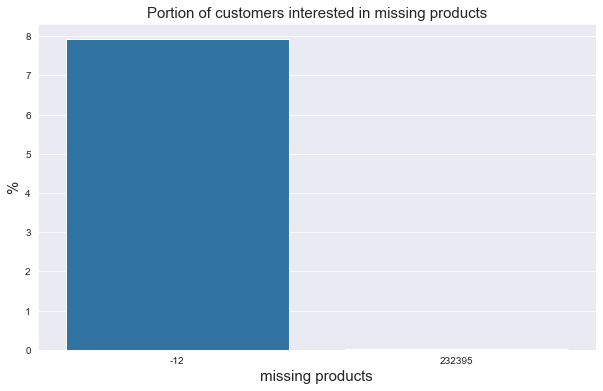

In [24]:
portion_12 = (len(product_12.CUSTOMER_ID.unique())/len(sales_detail.CUSTOMER_ID.unique()))*100
portion_232395 = (len(product_232395.CUSTOMER_ID.unique())/len(sales_detail.CUSTOMER_ID.unique()))*100
fig=plt.figure(figsize=(10,6))

sns.set_style('darkgrid')
sns.barplot(['-12','232395'],[portion_12,portion_232395]);
plt.title('Portion of customers interested in missing products',fontsize=15)
plt.xlabel('missing products',fontsize=15)
plt.ylabel('%',fontsize=15)
plt.show()

#### general interest for products 

In [25]:
products = sales_detail.PRODUCT_ID.unique()
counts = np.zeros((2,len(products)))
n_customers = len(sales_detail.CUSTOMER_ID.unique())
j=0
for product in products:
    counts[0,j] = int(product)
    counts[1,j] = len(sales_detail[sales_detail.PRODUCT_ID == product].CUSTOMER_ID.unique())/n_customers*100
    j+=1

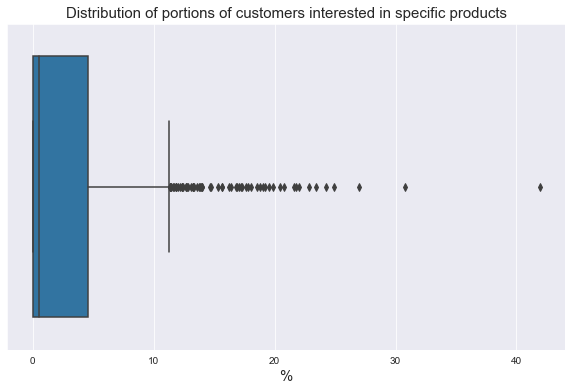

In [26]:
counts_df = pd.DataFrame(counts).T
counts_df.index = (counts_df[0])
counts_df.drop(0,axis=1,inplace=True)
fig=plt.figure(figsize=(10,6))
sns.boxplot(counts_df)
plt.title('Distribution of portions of customers interested in specific products',fontsize=15)
plt.xlabel('%',fontsize=15)
plt.show()

##### remove missing products?

Due to comparison that we made for both product -12 and product 232395 with the general interest shown by customers in products, we can conclude that 8% of customers interested is a significant value that we cannot ignore, as the mean value of portion of customers interested in a specific product is extremily below the 8%. So it would be a smart choice to keep the product -12 and get rid of the product 232395. Even if we can't have information about product -12, it can help in the segmentation of the customers

In [27]:
to_drop = sales_detail[sales_detail.PRODUCT_ID == 232395].index
sales_detail.drop(to_drop,inplace= True)

### Consistency - Quantity

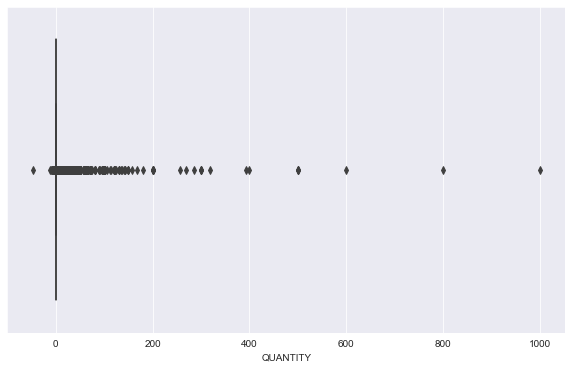

In [28]:
fig=plt.figure(figsize=(10,6))
sns.boxplot(sales_detail.QUANTITY);

#### check for quantity = 0 

In [29]:
null_qt = sales_detail[sales_detail.QUANTITY == 0] #check for null quantities
null_qt

CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL
882666  DL03352756  2019-09-07      185872       0.0         0.0     NaN
882667  DL03352756  2019-09-07      225211       0.0         0.0     NaN

#### check for those 2 products: 185872 , 225211	

In [30]:
print('There are {} non_null entries for product 185872'.format(sales_detail[sales_detail.PRODUCT_ID == 185872].shape[0]-1))
print('There are {} non_null entries for product 225211'.format(sales_detail[sales_detail.PRODUCT_ID == 225211].shape[0]-1))


There are 1225 non_null entries for product 185872
There are 599 non_null entries for product 225211


In [31]:
to_drop = null_qt.index # get indexes for null quantities
sales_detail.drop(to_drop,inplace=True)

In [32]:
negative_qt = sales_detail[sales_detail.QUANTITY < 0]
negative_qt

CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL
1840117  AF00367996  2018-07-07       94580      -1.0       -5.95     NaN
1914983  FP01408983  2018-07-12         252      -1.0       -7.95     NaN
1914984  FP01408983  2018-07-12      150317      -2.0      -11.90     NaN
1914985  FP01408983  2018-07-12        1273      -1.0      -11.95     NaN
1914986  FP01408983  2018-07-12        1789      -1.0       -3.35     NaN
...             ...         ...         ...       ...         ...     ...
893749   VP00968527  2020-01-22      207915      -1.0       -5.95     NaN
403638   XK01109631  2020-01-22       21223      -1.0       -7.65     NaN
172443   QQ05059366  2020-01-23        1921      -1.0      -12.65     NaN
411789   WG02985064  2020-01-24         288      -1.0       -7.95     NaN
278332   CQ00297859  2020-01-25       22208      -1.0      -15.95     NaN

[343 rows x 6 columns]

In [33]:
#abs_qt = abs(sales_detail.QUANTITY)
#sales_detail.QUANTITY = abs_qt

## Dealing with missing values

### Replace 'N' where null in sales_detail.SPECIAL

In [34]:
sales_detail.SPECIAL = sales_detail.SPECIAL.fillna('N')

### Check for price where missing in sales_detail.LIST_PRICE

In [35]:
missing_price = sales_detail[np.isnan(sales_detail.LIST_PRICE) == True]
print ('There are {} missing prices'.format(missing_price.shape[0]))

There are 21704 missing prices


In [36]:
negative_price = sales_detail[(sales_detail.LIST_PRICE) < 0]
print ('There are {} negative prices'.format(negative_price.shape[0]))

There are 20385 negative prices


In [37]:
null_price = sales_detail[(sales_detail.LIST_PRICE) == 0]
print ('There are {} null prices'.format(null_price.shape[0]))

There are 58455 null prices


#### abs of negative prices

In [38]:
#abs_price = abs(sales_detail.LIST_PRICE)
#sales_detail.LIST_PRICE = abs_price

#### missing and null prices

In [39]:
                         # create a dataframe without missing and null prices
    
sales_non_null = sales_detail.drop(null_price.index)
sales_non_null = sales_non_null.drop(missing_price.index)

                         # consider only positive prices
    
abs_price = abs(sales_non_null.LIST_PRICE)
sales_non_null.LIST_PRICE = abs_price

In [40]:
                         # compute the unity_prices for each transaction

unit_prices = sales_non_null.LIST_PRICE/sales_non_null.QUANTITY
sales_non_null['unit_price'] = unit_prices


In [41]:
            # when duplications of unity price incurred, replace a unique unity price for specific product 
    
list_products = sales_non_null.PRODUCT_ID.unique()
for product in list_products:
    to_check = sales_non_null[sales_non_null.PRODUCT_ID == product].unit_price.unique()
    if len(to_check)> 1:
        index = sales_non_null[sales_non_null.PRODUCT_ID == product].index
        mode = sales_non_null[sales_non_null.PRODUCT_ID == product].unit_price.mode()[0]
        mode_array = np.full(len(index),mode)
        sales_non_null.unit_price[index] = mode_array


/Users/pierfrancescomelucci/opt/anaconda3/envs/ENV/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


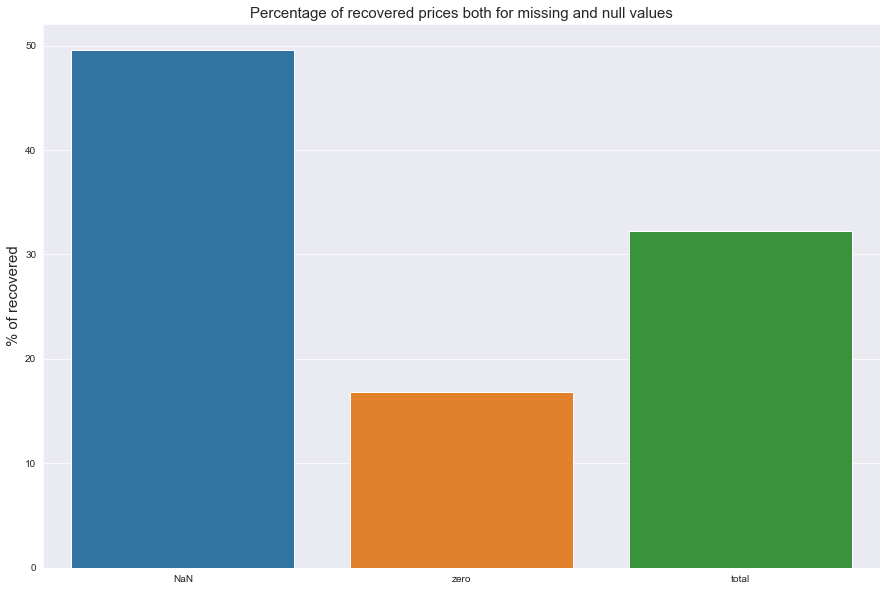

In [42]:
                    # Percentage of the restored unit product prices for products which prices were missing 
                    #                                   vs
                    # Percentage of the restored unit product prices for products which prices were null
    
                            # missing
missing_price_products = np.sort(missing_price.PRODUCT_ID.unique())
check_missing = [list_products[i] in missing_price_products 
         for i in range(len(list_products))] 
missing_recovered_percentage = check_missing.count(True)/len(missing_price_products)*100

                            # null
null_price_products = np.sort(null_price.PRODUCT_ID.unique())
check_null = [list_products[i] in null_price_products 
         for i in range(len(list_products))] # store the result in 'check' list
null_recovered_percentage = check_null.count(True)/len(null_price_products)*100

total = (check_missing.count(True)+check_null.count(True))/(len(null_price_products)+
                                                           len(missing_price_products))*100

                            # plot results
fig = plt.figure(figsize=(15,10))

sns.barplot(['NaN','zero','total'],
            [missing_recovered_percentage,null_recovered_percentage,total])

plt.title('Percentage of recovered prices both for missing and null values',fontsize=15)
plt.ylabel('% of recovered',fontsize=15)

plt.show()


#### correct prices where wrong

In [43]:
                                    # create a table for the unit_price
    
unit_price_table =sales_non_null[['PRODUCT_ID','unit_price']].sort_values('PRODUCT_ID').groupby('PRODUCT_ID').mean()



In [44]:
unit_price_table

unit_price
PRODUCT_ID            
-12               7.95
 36               6.95
 60               6.95
 96               6.95
 144              5.75
...                ...
 253285           9.95
 253513           7.25
 253525          14.95
 253537           7.65
 253753          13.95

[1043 rows x 1 columns]

In [45]:
                                # import the unit_price column
sales_detail['unit_price'] = sales_detail.PRODUCT_ID.map(unit_price_table.set_index(unit_price_table.index)['unit_price'])
sales_detail
                                # compute the correct price for each transaction
prices = sales_detail.unit_price * sales_detail.QUANTITY
sales_detail['LIST_PRICE'] = prices
sales_detail



CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL  \
1095985  AA00325975  2018-06-30         348       1.0        5.75       N   
1095986  AA00325975  2018-06-30         636       1.0        5.45       N   
1095987  AA00325975  2018-06-30       97741       1.0        6.35       N   
1095988  AA00325975  2018-06-30        2594       1.0        9.95       N   
1635482  AA01053942  2018-06-30       17356       1.0        6.65       N   
...             ...         ...         ...       ...         ...     ...   
414071   YQ02154745  2020-01-26      246797       1.0        4.45       N   
414311   YQ02154745  2020-01-26       12012       1.0        5.25       N   
596373   YV00655597  2020-01-26      111867       1.0       11.45       N   
596374   YV00655597  2020-01-26      130700       1.0        7.45       N   
596375   YV00655597  2020-01-26      243446       2.0       19.90       N   

         unit_price  
1095985        5.75  
1095986        5.45  
1095987        6.35  
1095988        9.95  
1635482        6.65  
...             ...  
414071         4.45  
414311         5.25  
596373        11.45  
596374         7.45  
596375         9.95  

[2047060 rows x 7 columns]

#### check for remaining missing values

In [46]:
                                # add Category_id to sales_detail

sales_detail['CATEGORY_ID'] = sales_detail.PRODUCT_ID.map(PRODUCT.set_index('PRODUCT_ID')['CATEGORY_ID'])
sales_detail.CATEGORY_ID = sales_detail.CATEGORY_ID.fillna(17)

In [47]:
missing_price = sales_detail[np.isnan(sales_detail.LIST_PRICE) == True]
print ('There are {} missing prices'.format(missing_price.shape[0]))

There are 56381 missing prices


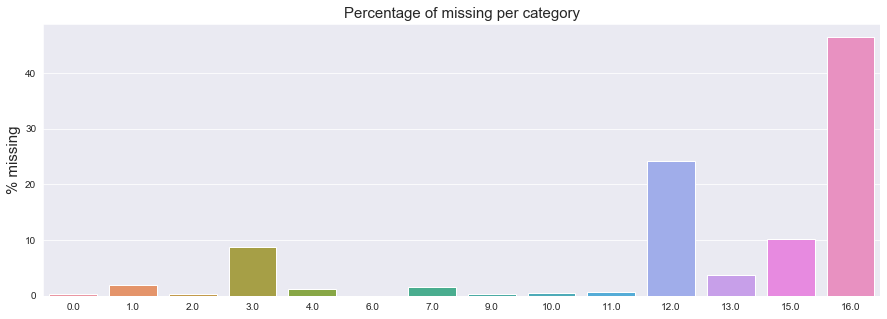

In [48]:
y = missing_price.CATEGORY_ID.value_counts()/len(missing_price)*100
x = missing_price.CATEGORY_ID.value_counts().index
fig = plt.figure(figsize=(15,5))

sns.barplot(x,y)

plt.title('Percentage of missing per category',fontsize=15)
plt.ylabel('% missing',fontsize=15)

plt.show()


In [49]:
sales_detail[['CATEGORY_ID','unit_price']].groupby('CATEGORY_ID').mean()

unit_price
CATEGORY_ID            
0.0           26.950000
1.0            7.541183
2.0            6.004831
3.0            7.178598
4.0           11.397750
6.0           11.095616
7.0           11.697715
9.0            4.729305
10.0           5.410159
11.0           7.514372
12.0           8.399854
13.0          10.433343
15.0                NaN
16.0           5.792736
17.0           7.950000

#### inspecting category 15, as no significant value has been entered

In [50]:
print('Description of category 15: {}'.format(PRODUCT[PRODUCT.CATEGORY_ID==15].CATEGORY_DESC.unique()[0]))

Description of category 15: GADGETS


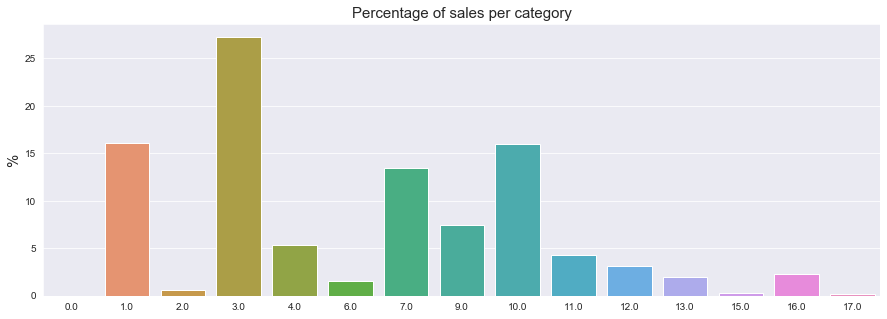

In [51]:
y = sales_detail.CATEGORY_ID.value_counts()/len(sales_detail)*100
x = sales_detail.CATEGORY_ID.value_counts().index
fig = plt.figure(figsize=(15,5))

sns.barplot(x,y)

plt.title('Percentage of sales per category',fontsize=15)
plt.ylabel('%',fontsize=15)

plt.show()

#### inspecting distribution of unit price in other categories

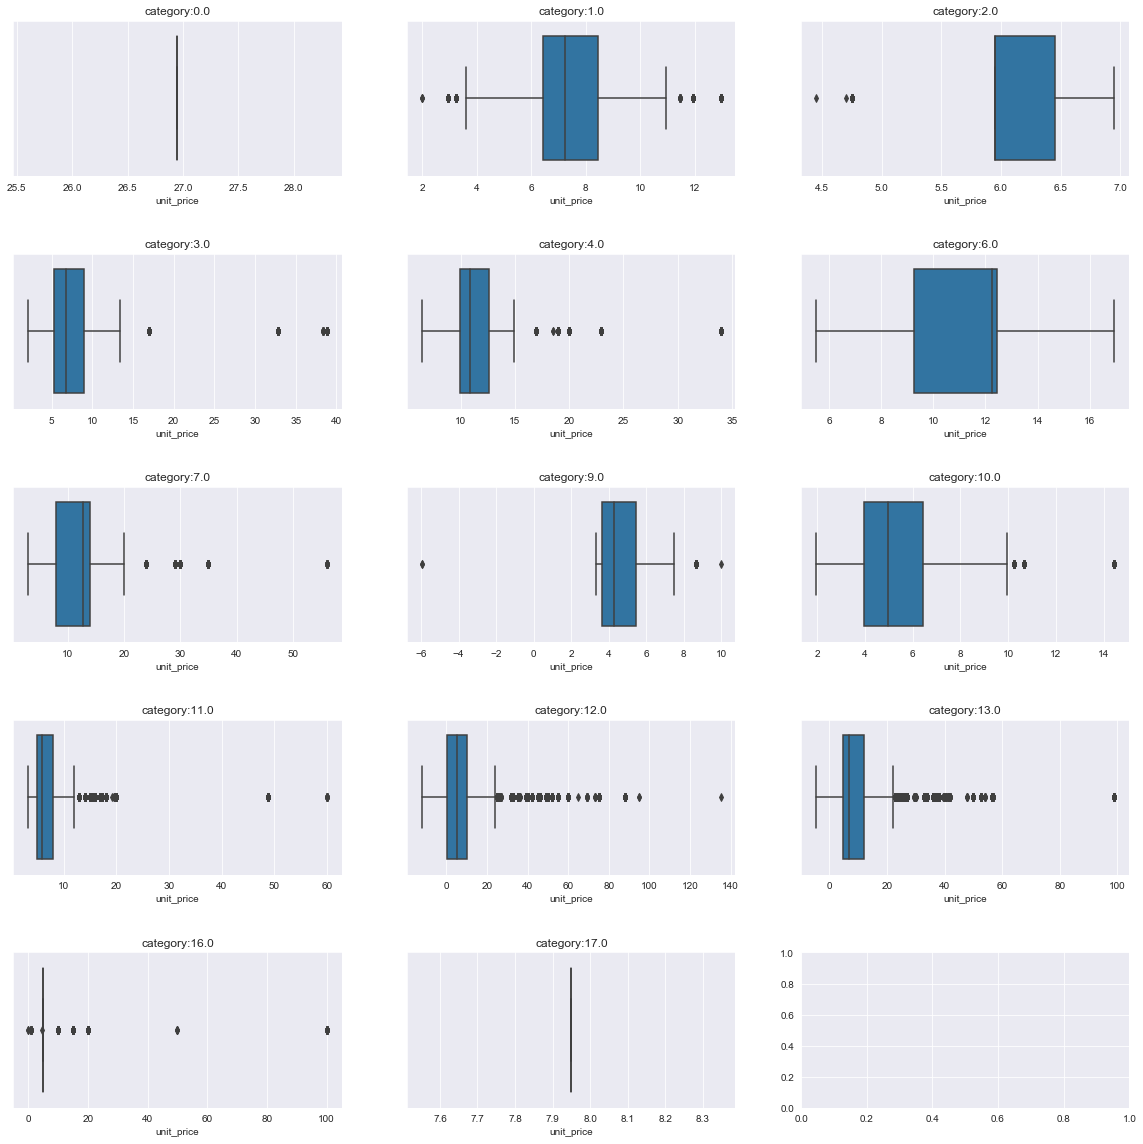

In [54]:
fig, ax = plt.subplots(figsize=(20,20), nrows=5, ncols=3)
counter = 0
for category in np.sort(x):
    if category != 15:
        i = counter//3; j = counter%3;
        y = sales_detail[sales_detail.CATEGORY_ID == category].unit_price
        sns.boxplot(y,ax=ax[i,j])
        ax[i,j].set_title('category:{}'.format(category))
        counter += 1

plt.subplots_adjust(hspace=0.5)

plt.show()


In [52]:
                              # update PRODUCT Table with product -12, category=17
    
missing_product = pd.DataFrame.from_dict({'PRODUCT_ID':[-12],'CATEGORY_ID':[17],'CATEGORY_DESC':['OTHER_MISSING']})
PRODUCT = PRODUCT.append(missing_product)

In [53]:
for category in PRODUCT.CATEGORY_ID.unique():

    print('Description of category {}: {}'.format(category,
                                                  PRODUCT[PRODUCT.CATEGORY_ID==category].CATEGORY_DESC.unique()[0]))



Description of category 0: OTHER
Description of category 1: OTHER_FROZEN
Description of category 2: SAUCE
Description of category 3: READY-MADE
Description of category 4: POULTRY
Description of category 6: BEEF_PORK
Description of category 7: FISH
Description of category 8: PASTRY
Description of category 9: FRIES
Description of category 10: VEGETABLES
Description of category 11: FRUIT
Description of category 12: ACCESSORIES
Description of category 13: DRINKS
Description of category 15: GADGETS
Description of category 16: OTHER
Description of category 17: OTHER_MISSING


In [54]:
                         # inspect categories 0 and 16, as they have same category description

c_16 = sales_detail[sales_detail.CATEGORY_ID == 16].PRODUCT_ID.unique()
c_0 = sales_detail[sales_detail.CATEGORY_ID == 0].PRODUCT_ID.unique()

check = [ c_16[i] in c_0 for i in range(len(c_16))]
check.count(True)

0

In [55]:
catgs = np.sort(missing_price.CATEGORY_ID.unique())
unit_prices_category = np.zeros(len(catgs))
i=0
for category in catgs:
    if category != 15:
        unit_prices_category[i] = sales_detail[sales_detail.CATEGORY_ID == category].unit_price.mode()
    i+=1
    
        

unit_prices_category = pd.DataFrame(unit_prices_category)
unit_prices_category.index = catgs
unit_prices_category.columns = ['unit_price']
unit_prices_category

unit_price
0.0        26.95
1.0         7.25
2.0         5.95
3.0         3.75
4.0         9.95
6.0        12.25
7.0         5.85
9.0         3.65
10.0        3.95
11.0        5.25
12.0        0.05
13.0        4.50
15.0        0.00
16.0        5.00

In [56]:
to_fix_category = pd.DataFrame(missing_price.CATEGORY_ID)
indexes = unit_prices_category.index
to_fix_category['unit_price'] = to_fix_category.CATEGORY_ID.map(unit_prices_category.set_index(indexes)['unit_price'])
fixed = to_fix_category.unit_price
to_fix_indexes = missing_price.index
sales_detail.unit_price[to_fix_indexes] = fixed


/Users/pierfrancescomelucci/opt/anaconda3/envs/ENV/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
sales_detail.LIST_PRICE = sales_detail.unit_price * sales_detail.QUANTITY
sales_detail

CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL  \
1095985  AA00325975  2018-06-30         348       1.0        5.75       N   
1095986  AA00325975  2018-06-30         636       1.0        5.45       N   
1095987  AA00325975  2018-06-30       97741       1.0        6.35       N   
1095988  AA00325975  2018-06-30        2594       1.0        9.95       N   
1635482  AA01053942  2018-06-30       17356       1.0        6.65       N   
...             ...         ...         ...       ...         ...     ...   
414071   YQ02154745  2020-01-26      246797       1.0        4.45       N   
414311   YQ02154745  2020-01-26       12012       1.0        5.25       N   
596373   YV00655597  2020-01-26      111867       1.0       11.45       N   
596374   YV00655597  2020-01-26      130700       1.0        7.45       N   
596375   YV00655597  2020-01-26      243446       2.0       19.90       N   

         unit_price  CATEGORY_ID  
1095985        5.75          1.0  
1095986        5.45          1.0  
1095987        6.35          3.0  
1095988        9.95          7.0  
1635482        6.65          3.0  
...             ...          ...  
414071         4.45          3.0  
414311         5.25         13.0  
596373        11.45          3.0  
596374         7.45          3.0  
596375         9.95          4.0  

[2047060 rows x 8 columns]

In [58]:
null_price = sales_detail[(sales_detail.LIST_PRICE) == 0]
print ('There are {} null prices, all belonging to Category: {}'.format(null_price.shape[0],
                                                                      int(null_price.CATEGORY_ID.unique()[0])))

There are 5729 null prices, all belonging to Category: 15


### Remove missing values in sales.TOTAL_POINTS

In [59]:
sales.TOTAL_POINTS = sales.TOTAL_POINTS.fillna(0)

### Remove missing values in registry.CREATION_DATE

In [60]:
registry[registry.CREATION_DATE.isnull() == True]

CUSTOMER_ID CREATION_DATE  REGIONAL_CODE ORIGIN
8887   IU00325003           NaN              1    WEB
11036  KX00414475           NaN             54    WEB
11044  KX01018163           NaN             34    WEB
13853  NO00992562           NaN             41    WEB
17249  QT00404897           NaN             42    WEB
17813  RH00414306           NaN             54    WEB
19316  SS00395804           NaN             13    WEB
21110  UM00405673           NaN             23    WEB

In [61]:
web_origin_dates = registry[registry.ORIGIN == 'WEB'].CREATION_DATE
years = []
for date in web_origin_dates:
    try:
        years.append(date[:4])
    except:
        pass

pd.Series(years).mode()

0    2003
dtype: object

In [62]:
registry.CREATION_DATE = registry.CREATION_DATE.fillna('2003-01-10')

### inspect cleaned dataset

In [63]:
inspect_missing(dataframes)



				Checking missing for sales	489965 items 

                missing  percentage
CUSTOMER_ID           0         0.0
DATE                  0         0.0
OUTLET_ID             0         0.0
PAYMENT_METHOD        0         0.0
TIME                  0         0.0
TOTAL_POINTS          0         0.0


				Checking missing for product	2800 items 

               missing  percentage
PRODUCT_ID           0         0.0
CATEGORY_ID          0         0.0
CATEGORY_DESC        0         0.0


				Checking missing for sales_detail	2047060 items 

             missing  percentage
CUSTOMER_ID        0         0.0
DATE               0         0.0
PRODUCT_ID         0         0.0
QUANTITY           0         0.0
LIST_PRICE         0         0.0
SPECIAL            0         0.0
unit_price         0         0.0
CATEGORY_ID        0         0.0


				Checking missing for registry	25727 items 

               missing  percentage
CUSTOMER_ID          0         0.0
CREATION_DATE        0         0.0
REGI

In [64]:
def where(df,col,value):
    view = df[df[col]==value]
    return view

## Inspect the data

#### preferred product

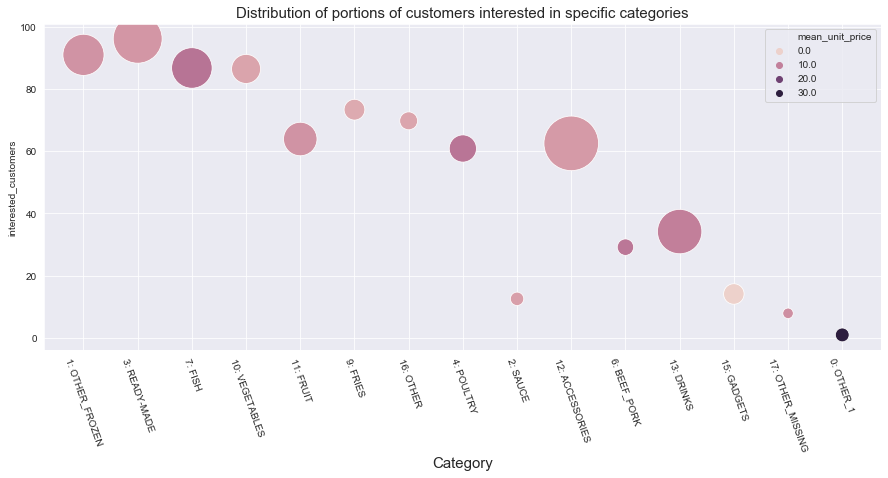

In [65]:
categories = sales_detail.CATEGORY_ID.unique()
counts = np.zeros((4,len(categories)))
n_customers = len(sales_detail.CUSTOMER_ID.unique())
j=0
for category in categories:
    counts[0,j] = int(category)
    counts[1,j] = len(sales_detail[sales_detail.CATEGORY_ID == category].CUSTOMER_ID.unique())/n_customers*100
    counts[2,j] = len(sales_detail[sales_detail.CATEGORY_ID == category].PRODUCT_ID.unique())
    counts[3,j] = sales_detail[sales_detail.CATEGORY_ID == category].unit_price.mean()
    j+=1
    
counts_df = pd.DataFrame(counts).T
counts_df.columns = ['CATEGORY_ID','interested_customers','n_products','mean_unit_price']
counts_df.sort_values('CATEGORY_ID')

fig=plt.figure(figsize=(15,6))

descriptions = []
for category in categories:
    description = PRODUCT[PRODUCT.CATEGORY_ID==category].CATEGORY_DESC.unique()[0]
    descriptions.append(str(int(category))+': '+ description)
descriptions.pop()
descriptions.append('0: OTHER_1')
x = descriptions
y = counts_df.interested_customers
sns.set_style('darkgrid')
sns.scatterplot(x,y,hue=counts_df.mean_unit_price,s=counts_df.n_products*10+100)
plt.title('Distribution of portions of customers interested in specific categories',fontsize=15)
plt.xlabel('Category',fontsize=15)
plt.xticks(rotation=-70)
plt.show()

# Get the customers table

## Create a foreign key to join detail and detail_sales

In [66]:
                                  # create the foreign key
    
sales['f_key'] = sales.CUSTOMER_ID+sales.DATE
sales

CUSTOMER_ID        DATE  OUTLET_ID PAYMENT_METHOD      TIME  \
80      AA00325975  2018-06-30          7     DEBIT CARD  11:28:16   
576     AA01053942  2018-06-30         25    CREDIT CARD  16:41:37   
721     AA01393171  2018-06-30         64    CREDIT CARD  13:33:32   
1443    AB01053149  2018-06-30         95     DEBIT CARD  10:19:54   
1627    AB01973926  2018-06-30         81     DEBIT CARD  12:15:21   
...            ...         ...        ...            ...       ...   
475629  YG01213021  2020-01-26         10           CASH  14:41:13   
476759  YI00811425  2020-01-26         87    CREDIT CARD  12:45:15   
481477  YO01393043  2020-01-26         89    CREDIT CARD  12:11:35   
483205  YQ02154745  2020-01-26         29           CASH  10:45:05   
486887  YV00655597  2020-01-26         18    CREDIT CARD  10:37:25   

        TOTAL_POINTS                 f_key  
80             220.0  AA003259752018-06-30  
576            615.0  AA010539422018-06-30  
721             90.0  AA013931712018-06-30  
1443           425.0  AB010531492018-06-30  
1627           280.0  AB019739262018-06-30  
...              ...                   ...  
475629         895.0  YG012130212020-01-26  
476759           0.0  YI008114252020-01-26  
481477        1600.0  YO013930432020-01-26  
483205       -1915.0  YQ021547452020-01-26  
486887         600.0  YV006555972020-01-26  

[489965 rows x 7 columns]

In [67]:
                                # check for duplication in forign key
    
occurence = sales.f_key.value_counts()
to_inspect = occurence[occurence.values > 1]
to_inspect.sum()

2042

In [68]:
                             # get indexes of duplications in foreign key
index = np.zeros(2042)
i=0
with tqdm(total=len(to_inspect.index)) as pbar:
    for key in to_inspect.index:
        til = len(sales[sales.f_key == key].index)
        index[i:i+til] = sales[sales.f_key == key].index
        i+=til
        pbar.update(1)


In [69]:
                             # check if the purchasing belong to same outlet_id
customers_more = np.array([])
to_inspect = sales.loc[index]
for key in to_inspect.f_key:
    counts = to_inspect[to_inspect.f_key == key].OUTLET_ID.value_counts()
    if counts.shape[0] > 1:
            customers_more = np.append(customers_more,[key])
if len(customers_more) == 0:
    print('For transaction occured at different hours in same day, there are not multiple outlet recorded')

For transaction occured at different hours in same day, there are not multiple outlet recorded


In [70]:
duplicate = sales.loc[index]

In [71]:
                             # get rid of duplications in foriegn key
def avoid_duplication(df):
    keys = df.f_key.unique()
    to_drop = []
    with tqdm(total=len(keys)) as pbar:
        for key in keys:
            repetitions_indexes = df[df.f_key == key].index[1:].values
            for i in repetitions_indexes:
                to_drop.append(i)
            pbar.update(1)      
    return to_drop
to_drop = avoid_duplication(duplicate)        

#### remove duplications

In [72]:
sales.drop(to_drop,inplace=True)

#### get a view for unique client and date (foreign key)

In [73]:
sales.index = range(len(sales))

In [74]:
sales_detail['f_key'] = sales_detail.CUSTOMER_ID+sales_detail.DATE
view = sales_detail.groupby(['f_key']).sum()

In [75]:
view

PRODUCT_ID  QUANTITY  LIST_PRICE  unit_price  \
f_key                                                                
AA003121882018-07-04      104680       3.0       24.05       24.05   
AA003121882018-07-20      146542       4.0       37.60       29.95   
AA003121882018-08-16      364572       3.0       25.65       25.65   
AA003121882018-09-13      408016       5.0       35.15       35.15   
AA003121882018-09-27      330903       3.0       22.15       22.15   
...                          ...       ...         ...         ...   
YZ049339872019-10-25      990042       7.0       50.15       50.15   
YZ049339872019-11-10     2078141      23.0      126.60      126.60   
YZ049339872019-11-22      799052       8.0       57.55       57.55   
YZ049339872019-12-06     1075581       8.0       52.70       47.70   
YZ049339872019-12-20      235306       8.0       50.00       50.00   

                      CATEGORY_ID  
f_key                              
AA003121882018-07-04         18.0  
AA003121882018-07-20         11.0  
AA003121882018-08-16         10.0  
AA003121882018-09-13         40.0  
AA003121882018-09-27         32.0  
...                           ...  
YZ049339872019-10-25         54.0  
YZ049339872019-11-10        147.0  
YZ049339872019-11-22         53.0  
YZ049339872019-12-06         43.0  
YZ049339872019-12-20         55.0  

[488885 rows x 5 columns]

In [76]:
sales['Expense'] = sales.f_key.map(view.set_index(view.index)['LIST_PRICE'])
sales['ITEMS'] = sales.f_key.map(view.set_index(view.index)['QUANTITY'])

In [77]:
sales_detail.to_csv('sales_detail_category.csv',index=False,header=True)

## Retrieve informations

#### get number of week

In [78]:

import calendar                                # convert column date to date object
from datetime import datetime
sales.DATE = pd.to_datetime(sales.DATE)

In [79]:
sales.DATE[483205]

Timestamp('2020-01-21 00:00:00')

In [80]:
start = datetime.strptime('2018-07-02', '%Y-%m-%d')
((sales.DATE[80]-start).days//7)

-1

In [81]:
weeks=np.zeros(len(sales.DATE))
days=np.zeros(len(sales.DATE))
i=0
for date in sales.DATE:
    weeks[i] = (date-start).days//7 + 1
    days[i] = date.weekday()
    i+=1

In [82]:
sales['day_of_week'] = days

In [83]:
sales['WEEK'] = weeks

In [84]:
sales[sales.WEEK==1]

CUSTOMER_ID       DATE  OUTLET_ID PAYMENT_METHOD      TIME  TOTAL_POINTS  \
1032  AA00339963 2018-07-03          8           CASH  13:22:54         105.0   
1033  AA03422302 2018-07-03         92    CREDIT CARD  20:07:48         255.0   
1034  AC03216433 2018-07-03         87           CASH  10:23:44         115.0   
1035  AF00351492 2018-07-03          8    CREDIT CARD  12:18:23         430.0   
1036  AF00434211 2018-07-03         19           CASH  17:30:05         130.0   
...          ...        ...        ...            ...       ...           ...   
5517  YF00968777 2018-07-08         91           CASH  10:36:41          70.0   
5518  YL00339699 2018-07-08          7           CASH  15:10:49         160.0   
5519  YN01752285 2018-07-08         83    CREDIT CARD  11:42:35         245.0   
5520  YV00655597 2018-07-08         18    CREDIT CARD  11:01:31         160.0   
5521  YX00755748 2018-07-08         18           CASH  11:03:57         130.0   

                     f_key  Expense  ITEMS  day_of_week  WEEK  
1032  AA003399632018-07-03    15.80    2.0          1.0   1.0  
1033  AA034223022018-07-03    38.25    6.0          1.0   1.0  
1034  AC032164332018-07-03    17.90    2.0          1.0   1.0  
1035  AF003514922018-07-03    60.50   10.0          1.0   1.0  
1036  AF004342112018-07-03    20.10    2.0          1.0   1.0  
...                    ...      ...    ...          ...   ...  
5517  YF009687772018-07-08    11.60    2.0          6.0   1.0  
5518  YL003396992018-07-08    23.35    3.0          6.0   1.0  
5519  YN017522852018-07-08    31.60    4.0          6.0   1.0  
5520  YV006555972018-07-08    18.40    2.0          6.0   1.0  
5521  YX007557482018-07-08    19.55    3.0          6.0   1.0  

[4490 rows x 11 columns]

#### get month in sales

In [85]:
months = np.array([])
with tqdm(total=len(sales)) as pbar:
    for i in range(len(sales)):
        month = sales.DATE[i].month
        months = np.append(months,month)
        pbar.update(1)

In [86]:
sales['MONTH'] = months

#### get year in sales

In [87]:
years = np.array([])
with tqdm(total=len(sales)) as pbar:
    for i in range(len(sales)):
        year = sales.DATE[i].year
        years = np.append(years,year)
        pbar.update(1)

In [88]:
sales['YEAR'] = years

#### get season of the year

In [727]:
                            # create a table for months
months = pd.DataFrame()
months['Month'] = range(1,13)
season = []
for i in range(1,13):
    if i < 3:
        season.append('Winter')
    else:
        if i < 6:
            season.append('Spring')
        else:
            if i < 9:
                season.append('Summer')
            else:
                if i < 12:
                    season.append('Fall')
                else:
                    season.append('Winter')
        
months['Season'] = season


In [729]:
sales['Season'] = sales.MONTH.map(months.set_index('Month')['Season'])

#### get moment of the day

In [89]:
orari = pd.to_datetime(sales.TIME, format="%H:%M:%S").dt.time
_8_am = datetime.strptime('8:00:00', '%H:%M:%S').time()
_12_am = datetime.strptime('12:00:00', '%H:%M:%S').time()
_14_pm = datetime.strptime('14:00:00', '%H:%M:%S').time()
_19_pm = datetime.strptime('19:00:00', '%H:%M:%S').time()
_21_pm = datetime.strptime('21:00:00', '%H:%M:%S').time()

In [90]:
morning = orari<=_12_am 
to_drop = morning[morning==True].index
to_check = orari.drop(to_drop)

launch = to_check<_14_pm 
to_drop = launch[launch==True].index
to_check = to_check.drop(to_drop)

afternoon = to_check<=_19_pm 
to_drop = afternoon[afternoon==True].index
to_check = to_check.drop(to_drop)

dinner = to_check<=_21_pm 
to_drop = dinner[dinner==True].index
night = to_check.drop(to_drop)

In [ ]:
orari[morning.index] = 'morning'
orari[launch.index] = 'launch'
orari[afternoon.index] = 'afternoon'
orari[night.index] = 'night'

In [ ]:
sales['orario'] = orari

#### get moment of week

In [91]:
part_of_week = pd.DataFrame()
part_of_week['days'] = np.sort(sales.day_of_week.unique())
ferial = []
for day in np.sort(sales.day_of_week.unique()):
    if day == 0:
        ferial.append('monday')
    else:
        if day == 1:
            ferial.append('Tuesday')
        else:
            if day== 2:
                ferial.append('Wednesday')
            else:
                if day== 3:
                    ferial.append('Thursday')
                else:
                    if day== 4:
                        ferial.append('Friday')
                    else:
                        if day== 4:
                            ferial.append('Saturday')
                        else:
                            ferial.append('Sunday')

part_of_week['feriale'] = ferial

In [92]:
sales['feriale'] = sales.day_of_week.map(part_of_week.set_index('days')['feriale'])

In [96]:
sales

CUSTOMER_ID       DATE  OUTLET_ID PAYMENT_METHOD      TIME  \
0       AA00325975 2018-06-30          7     DEBIT CARD  11:28:16   
1       AA01053942 2018-06-30         25    CREDIT CARD  16:41:37   
2       AA01393171 2018-06-30         64    CREDIT CARD  13:33:32   
3       AB01053149 2018-06-30         95     DEBIT CARD  10:19:54   
4       AB01973926 2018-06-30         81     DEBIT CARD  12:15:21   
...            ...        ...        ...            ...       ...   
488934  YG01213021 2020-01-26         10           CASH  14:41:13   
488935  YI00811425 2020-01-26         87    CREDIT CARD  12:45:15   
488936  YO01393043 2020-01-26         89    CREDIT CARD  12:11:35   
488937  YQ02154745 2020-01-26         29           CASH  10:45:05   
488938  YV00655597 2020-01-26         18    CREDIT CARD  10:37:25   

        TOTAL_POINTS                 f_key  Expense  ITEMS  day_of_week  WEEK  \
0              220.0  AA003259752018-06-30    27.50    4.0          5.0   0.0   
1              615.0  AA010539422018-06-30    78.20   10.0          5.0   0.0   
2               90.0  AA013931712018-06-30    13.90    2.0          5.0   0.0   
3              425.0  AB010531492018-06-30    57.00    6.0          5.0   0.0   
4              280.0  AB019739262018-06-30    36.35    7.0          5.0   0.0   
...              ...                   ...      ...    ...          ...   ...   
488934         895.0  YG012130212020-01-26    64.20   10.0          6.0  82.0   
488935           0.0  YI008114252020-01-26    13.95    1.0          6.0  82.0   
488936        1600.0  YO013930432020-01-26   102.10   20.0          6.0  82.0   
488937       -1915.0  YQ021547452020-01-26    33.30    6.0          6.0  82.0   
488938         600.0  YV006555972020-01-26    38.80    4.0          6.0  82.0   

        MONTH    YEAR feriale  new_c_key  
0         6.0  2018.0  Sunday          2  
1         6.0  2018.0  Sunday         22  
2         6.0  2018.0  Sunday         29  
3         6.0  2018.0  Sunday         71  
4         6.0  2018.0  Sunday         77  
...       ...     ...     ...        ...  
488934    1.0  2020.0  Sunday      24961  
488935    1.0  2020.0  Sunday      25025  
488936    1.0  2020.0  Sunday      25272  
488937    1.0  2020.0  Sunday      25357  
488938    1.0  2020.0  Sunday      25555  

[488939 rows x 15 columns]

In [98]:
day=pd.read_csv('days.csv')

In [99]:
day

CUSTOMER_ID   Tuesday  Wednesday  Thursday    Friday  Saturday  \
0      AA00312188  0.000000   0.040000  0.800000  0.040000  0.040000   
1      AA00312390  0.033333   0.000000  0.066667  0.000000  0.900000   
2      AA00325975  0.000000   0.000000  0.000000  0.028571  0.971429   
3      AA00336843  0.000000   0.045455  0.454545  0.181818  0.272727   
4      AA00339761  0.000000   0.000000  0.000000  0.941176  0.000000   
...           ...       ...        ...       ...       ...       ...   
25722  YZ04556116  1.000000   0.000000  0.000000  0.000000  0.000000   
25723  YZ04586406  0.000000   0.000000  0.800000  0.200000  0.000000   
25724  YZ04658257  0.000000   0.000000  0.000000  0.818182  0.090909   
25725  YZ04743693  0.200000   0.800000  0.000000  0.000000  0.000000   
25726  YZ04933987  0.000000   0.000000  0.000000  0.800000  0.000000   

         Sunday  CLUSTER  
0      0.080000        3  
1      0.000000        2  
2      0.000000        2  
3      0.045455        3  
4      0.058824        0  
...         ...      ...  
25722  0.000000        4  
25723  0.000000        3  
25724  0.090909        0  
25725  0.000000        1  
25726  0.200000        0  

[25727 rows x 8 columns]

In [100]:
sales['day_cluster'] = sales.new_c_key.map(day.set_index(day.index)['CLUSTER'])

In [102]:
sales.to_csv('sales_all.csv',header=True,index=False)

# Create table for customers

In [1043]:
def get_value_counts(df,df_inspect,list_):
    

    for col in list_:
        print('Retrieving values for {}'.format(col))
        c_cols = np.sort(df_inspect[col].unique())
        to_append = pd.DataFrame(np.zeros((n_customers,len(c_cols))))
        to_append.columns = c_cols
        to_append

        with tqdm(total=len(n_clients)) as pbar:
            for client in n_clients:
                view = df_inspect[df_inspect.new_c_key == client][col]
                count = view.value_counts()
                founded = count.index
                count=count.values/len(view)
                i=0
                for f in founded:
                    to_append.loc[client,f] = count[i]
                    i+=1

                pbar.update(1)

        df = pd.concat([df, to_append], axis=1)


    return(df)

## get total expense, avg expense for customer

In [94]:
                            # get number of unique customers
n_customers = len(sales_detail.CUSTOMER_ID.unique())

                            # get sorted list of customers
clients = np.sort(sales_detail.CUSTOMER_ID.unique())

In [95]:
  
         # create a new key for customers id, which helps to reduce computation time of slicing the database
        
new_key = pd.DataFrame(np.zeros((n_customers,1)))
new_key.index = clients
new_key['new_c_key'] = range(len(clients))
sales['new_c_key'] = sales.CUSTOMER_ID.map(new_key.set_index(new_key.index)['new_c_key'])
n_clients=new_key.new_c_key
n_clients = n_clients.values

In [1046]:
customers = pd.DataFrame()
customers['CUSTOMER_ID']= clients


## get weekly expense, monthly expense

In [1047]:
                                 # weekly expence , weekly purchasings

with tqdm(total=len(clients)*2) as pbar:
    for year in [2018,2019]:
        week_expenses = np.array([])
        week_times = np.array([])
        weeks = sales[sales.YEAR==year].WEEK.unique()
        
        for client in n_clients:
            customer_view = sales[sales.new_c_key == client]
            years = customer_view.YEAR.unique()
            view_year = customer_view[customer_view.YEAR==year]
            week_expenses = np.append(week_expenses,(view_year.Expense.sum()/len(weeks)))
            customer_week = view_year.WEEK
            times = customer_week.value_counts().values.sum()/len(weeks)
            week_times = np.append(week_times,times)
            
            pbar.update(1)
        col1 = '{}_weekly_expence'.format(int(year))
        col2 = '{}_weekly_purchasings'.format(int(year))
        customers[col1] = week_expenses
        customers[col2] = week_times
            
        

In [1048]:
                                 # monthly expence , monthly purchasings

with tqdm(total=len(clients)*2) as pbar:
    for year in [2018,2019]:
        month_expenses = np.array([])
        month_times = np.array([])
        months = sales[sales.YEAR==year].MONTH.unique()
        
        for client in n_clients:
            customer_view = sales[sales.new_c_key == client]
            years = customer_view.YEAR.unique()
            view_year = customer_view[customer_view.YEAR==year]
            month_expenses = np.append(month_expenses,(view_year.Expense.sum()/len(months)))
            customer_month = view_year.MONTH
            times = customer_month.value_counts().values.sum()/len(months)
            month_times = np.append(month_times,times)
            
            pbar.update(1)
        col1 = '{}_monthly_expence'.format(int(year))
        col2 = '{}_monthly_purchasings'.format(int(year))
        customers[col1] = month_expenses
        customers[col2] = month_times
          

### get average expence for single purchasings

In [1049]:
avg_expences = np.array([])
with tqdm(total=len(clients)) as pbar:
    
    for client in n_clients:
        customer_view = sales[sales.new_c_key == client]
        avg = customer_view.Expense.mean()
        avg_expences = np.append(avg_expences,avg)
        pbar.update(1)


In [1050]:
customers['avg_expence'] = avg_expenses


## get payment method, orario , moment_of_week

In [1051]:
customers = get_value_counts(customers,sales,['PAYMENT_METHOD','orario','feriale'])

Retrieving values for PAYMENT_METHOD



Retrieving values for orario



Retrieving values for feriale


In [1052]:
sales_detail['new_c_key'] = sales_detail.CUSTOMER_ID.map(new_key.set_index(new_key.index)['new_c_key'])

## get origin of registry?

In [1053]:
registry['new_c_key'] = registry.CUSTOMER_ID.map(new_key.set_index(new_key.index)['new_c_key'])

In [1054]:
#customers = get_value_counts(customers,registry,['ORIGIN'])

Retrieving values for ORIGIN


### get quantity per categories

In [1055]:
                                # get different categories 
categories = np.sort(sales_detail.CATEGORY_ID.unique())
indexes = PRODUCT[PRODUCT.CATEGORY_ID==0].index
for i in indexes:
    PRODUCT.loc[i,'CATEGORY_DESC']='OTHER_0'
                    # delete product 8, as it isn't present in transaction of sales_detail
indexes = PRODUCT[PRODUCT.CATEGORY_ID==8].index
PRODUCT.drop(indexes,inplace=True)
                    # get decription of category
columns = list(PRODUCT.groupby('CATEGORY_DESC').mean().sort_values('CATEGORY_ID').index)

In [1056]:
customers_cat = pd.DataFrame(np.zeros((n_customers,len(categories))))
customers_cat.index = range(len(clients))
customers_cat.columns = categories

with tqdm(total=len(clients)) as pbar:
    for client in n_clients:
        customer_view = sales_detail[sales_detail.new_c_key == client]
        purchased_category = customer_view.CATEGORY_ID.unique()
        quantities = customer_view.QUANTITY.sum()
        for cat in purchased_category:
            cat_counts = customer_view[customer_view.CATEGORY_ID == cat].QUANTITY.sum()/quantities
            customers_cat.loc[client,cat] = cat_counts
            
        pbar.update(1)
        
customers_cat.columns = columns
customers = pd.concat([customers, customers_cat], axis=1)
customers_cat

/Users/pierfrancescomelucci/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


OTHER_0  OTHER_FROZEN     SAUCE  READY-MADE   POULTRY  BEEF_PORK  \
0          0.0      0.040000  0.000000    0.168000  0.168000   0.000000   
1          0.0      0.102564  0.000000    0.307692  0.012821   0.000000   
2          0.0      0.311005  0.009569    0.267943  0.033493   0.009569   
3          0.0      0.126761  0.000000    0.492958  0.000000   0.000000   
4          0.0      0.238806  0.000000    0.238806  0.000000   0.000000   
...        ...           ...       ...         ...       ...        ...   
25722      0.0      0.333333  0.000000    0.222222  0.000000   0.000000   
25723      0.0      0.190476  0.000000    0.460317  0.007937   0.000000   
25724      0.0      0.070588  0.000000    0.252941  0.023529   0.005882   
25725      0.0      0.133333  0.000000    0.266667  0.000000   0.000000   
25726      0.0      0.074074  0.000000    0.388889  0.055556   0.018519   

           FISH     FRIES  VEGETABLES     FRUIT  ACCESSORIES    DRINKS  \
0      0.144000  0.048000    0.264000  0.032000     0.024000  0.088000   
1      0.000000  0.448718    0.102564  0.000000     0.000000  0.025641   
2      0.066986  0.086124    0.133971  0.038278     0.019139  0.000000   
3      0.028169  0.084507    0.211268  0.014085     0.028169  0.000000   
4      0.014925  0.014925    0.358209  0.000000     0.134328  0.000000   
...         ...       ...         ...       ...          ...       ...   
25722  0.111111  0.000000    0.000000  0.000000     0.000000  0.000000   
25723  0.111111  0.023810    0.174603  0.007937     0.000000  0.015873   
25724  0.064706  0.058824    0.105882  0.029412     0.288235  0.064706   
25725  0.066667  0.066667    0.066667  0.133333     0.066667  0.000000   
25726  0.000000  0.129630    0.148148  0.074074     0.000000  0.000000   

        GADGETS     OTHER  OTHER_MISSING  
0      0.000000  0.008000          0.016  
1      0.000000  0.000000          0.000  
2      0.000000  0.023923          0.000  
3      0.000000  0.014085          0.000  
4      0.000000  0.000000          0.000  
...         ...       ...            ...  
25722  0.222222  0.111111          0.000  
25723  0.000000  0.007937          0.000  
25724  0.000000  0.035294          0.000  
25725  0.000000  0.200000          0.000  
25726  0.000000  0.111111          0.000  

[25727 rows x 15 columns]

### get expence per season

In [1057]:
                                # get different categories 
seasons = np.sort(sales.Season.unique())

customers_season = pd.DataFrame(np.zeros((n_customers,len(seasons))))
customers_season.index = range(len(clients))
customers_season.columns = seasons

In [1058]:
with tqdm(total=len(clients)) as pbar:
    sales_2019=sales[sales.YEAR == 2019]
    for client in n_clients:
        customer_view = sales_2019[sales_2019.new_c_key == client]
        total_exp = customer_view.Expense.sum()
        exp_season = customer_view.groupby('Season').sum()
        seasons = exp_season.index
        for s in seasons:
            s_exp = exp_season.loc[s].Expense
            customers_season.loc[client,s] = s_exp/total_exp
            
        pbar.update(1)


/Users/pierfrancescomelucci/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [1059]:
customers = pd.concat([customers, customers_season], axis=1)

## acquired points vs spent points

In [1060]:

points = pd.DataFrame(np.zeros((n_customers,2)))
points.index = range(len(clients))
points.columns = ['Acquired','Spent']

In [1061]:
with tqdm(total=len(clients)) as pbar:

    for client in n_clients:
        customer_view = sales[sales.new_c_key == client]
        c_points = customer_view.TOTAL_POINTS
        acquired = c_points[c_points>0].mean()
        points.loc[client,'Acquired'] = acquired
        spent = abs(c_points[c_points<0].mean())
        points.loc[client,'Spent'] = spent
            
        pbar.update(1)


In [1062]:
points = points.fillna(0)

In [1063]:
customers = pd.concat([customers, points], axis=1)

## get Fidelty

In [1064]:
Fidelty = np.array([])
with tqdm(total=len(clients)) as pbar:

    for client in n_clients:
        outlet_c = sales[sales.new_c_key == client].OUTLET_ID
        mode = outlet_c.mode()[0]
        mode_frequency = list(outlet_c).count(mode)
        fidelty = mode_frequency/len(outlet_c)
        Fidelty = np.append(Fidelty,fidelty)

            
        pbar.update(1)

In [1065]:
customers['FIDELTY'] = Fidelty

## get expensiveness of products

In [1066]:
product_sales = pd.DataFrame(sales_detail.groupby('PRODUCT_ID').mean())[['unit_price',
                                                                        'CATEGORY_ID']]
product_sales['PRODUCT_ID'] = product_sales.index


In [1067]:
qualities = np.array([])
with tqdm(total=len(product_sales.index)) as pbar:
    for product in product_sales.index:
        category = product_sales.loc[product].CATEGORY_ID
        Q3 = product_sales[product_sales.CATEGORY_ID==category].unit_price.quantile(0.75)
        Q1 = product_sales[product_sales.CATEGORY_ID==category].unit_price.quantile(0.25)
        unit_price = product_sales.loc[product].unit_price
        if unit_price < Q1:
            quality = 'cheap'
        else:
            if unit_price < Q3:
                quality = 'normal'
            else:
                if unit_price < Q3 + (Q3-Q1)*1.5:
                    quality = 'expensive'
                else:
                    quality = 'very expensive'

        qualities = np.append(qualities,quality)
        pbar.update(1)            

        

In [1068]:
product_sales['Quality'] = qualities

In [1069]:
sales_detail['Quality'] = sales_detail.PRODUCT_ID.map(product_sales.set_index(product_sales.index)['Quality'])


In [1070]:
customers = get_value_counts(customers,sales_detail,['Quality'])

Retrieving values for Quality


In [1071]:
customers

CUSTOMER_ID  2018_weekly_expence  2018_weekly_purchasings  \
0      AA00312188            12.009259                 0.370370   
1      AA00312390             5.148148                 0.370370   
2      AA00325975            15.451852                 0.407407   
3      AA00336843             3.555556                 0.222222   
4      AA00339761             9.168519                 0.296296   
...           ...                  ...                      ...   
25722  YZ04556116             0.000000                 0.000000   
25723  YZ04586406             0.000000                 0.000000   
25724  YZ04658257             0.000000                 0.000000   
25725  YZ04743693             0.000000                 0.000000   
25726  YZ04933987             0.000000                 0.000000   

       2019_weekly_expence  2019_weekly_purchasings  2018_monthly_expence  \
0                10.169811                 0.264151             46.321429   
1                 6.018868                 0.339623             19.857143   
2                16.885849                 0.415094             59.600000   
3                 6.541509                 0.283019             13.714286   
4                 4.017925                 0.150943             35.364286   
...                    ...                      ...                   ...   
25722             0.886792                 0.037736              0.000000   
25723            14.323585                 0.245283              0.000000   
25724            17.783019                 0.169811              0.000000   
25725             1.591509                 0.075472              0.000000   
25726             6.358491                 0.094340              0.000000   

       2018_monthly_purchasings  2019_monthly_expence  \
0                      1.428571             44.916667   
1                      1.428571             26.583333   
2                      1.571429             74.579167   
3                      0.857143             28.891667   
4                      1.142857             17.745833   
...                         ...                   ...   
25722                  0.000000              3.916667   
25723                  0.000000             63.262500   
25724                  0.000000             78.541667   
25725                  0.000000              7.029167   
25726                  0.000000             28.083333   

       2019_monthly_purchasings  avg_expence  ...    Spring    Summer  \
0                      1.166667    36.702000  ...  0.203525  0.134323   
1                      1.500000    15.730000  ...  0.344357  0.215831   
2                      1.833333    39.897143  ...  0.221968  0.274261   
3                      1.250000    21.643182  ...  0.384050  0.202481   
4                      0.666667    29.414706  ...  0.352665  0.281052   
...                         ...          ...  ...       ...       ...   
25722                  0.166667    23.500000  ...  0.000000  1.000000   
25723                  1.083333    54.246667  ...  0.000000  0.228479   
25724                  0.750000    89.163636  ...  0.000000  0.124881   
25725                  0.333333    17.620000  ...  0.000000  0.000000   
25726                  0.416667    67.400000  ...  0.000000  0.000000   

         Winter    Acquired   Spent   FIDELTY     cheap  expensive    normal  \
0      0.313265  248.333333  2920.0  0.800000  0.278846   0.115385  0.548077   
1      0.180408  112.708333   560.0  0.966667  0.396552   0.327586  0.206897   
2      0.248897  305.909091  6602.5  0.971429  0.336585   0.160976  0.463415   
3      0.282088  133.333333  3465.0  0.454545  0.217391   0.101449  0.623188   
4      0.240197  200.625000  2015.0  1.000000  0.050847   0.389831  0.423729   
...         ...         ...     ...       ...       ...        ...       ...   
25722  0.000000  295.000000     0.0  0.500000  0.222222   0.111111  0.111111   
25723  0.215109  388.000000     0.0  0.600000  0.353659   0.182927  0.4512

In [1311]:
                                       # save the data 
customers = customers.fillna(0)
customers.to_csv('customers_true.csv',index=False,header=True)

# Scaling data

In [1089]:
from sklearn.preprocessing import StandardScaler, RobustScaler , MinMaxScaler
to_pca = customers.drop('CUSTOMER_ID',axis=1)

In [1090]:
scaler = MinMaxScaler()
scaler.fit(to_pca)

customers_scaled = scaler.transform(to_pca)


## pca


In [1093]:
pca = decomposition.PCA(n_components=10,)
pca.fit(customers_scaled)
pca_components = pd.DataFrame(pca.transform(customers_scaled))
i=1
explained_variance=0
for e_v in pca.explained_variance_ratio_:
    explained_variance+=e_v
    print('component',i,'\t',explained_variance)
    i+=1


component 1 	 0.2206455919729128
component 2 	 0.35854848728847416
component 3 	 0.4761767844438679
component 4 	 0.5808903973526882
component 5 	 0.6724566352927991
component 6 	 0.7311792196290624
component 7 	 0.7792957156051138
component 8 	 0.8087698048870147
component 9 	 0.8342017004067909
component 10 	 0.8590718902806254


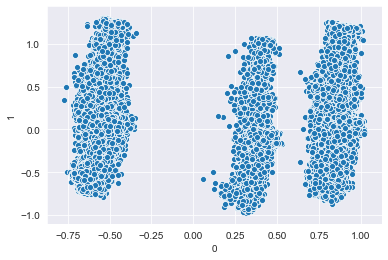

In [1094]:
sns.scatterplot(pca_components[0],pca_components[1])

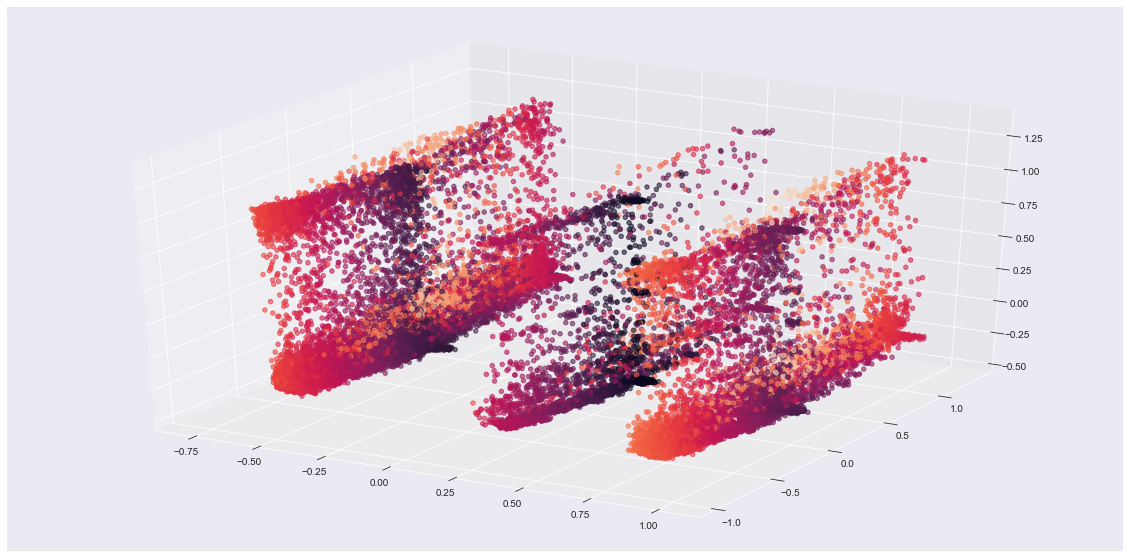

In [1112]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_components[0],pca_components[1],pca_components[2],alpha=0.6,
          c=pca_components[3])

plt.show()

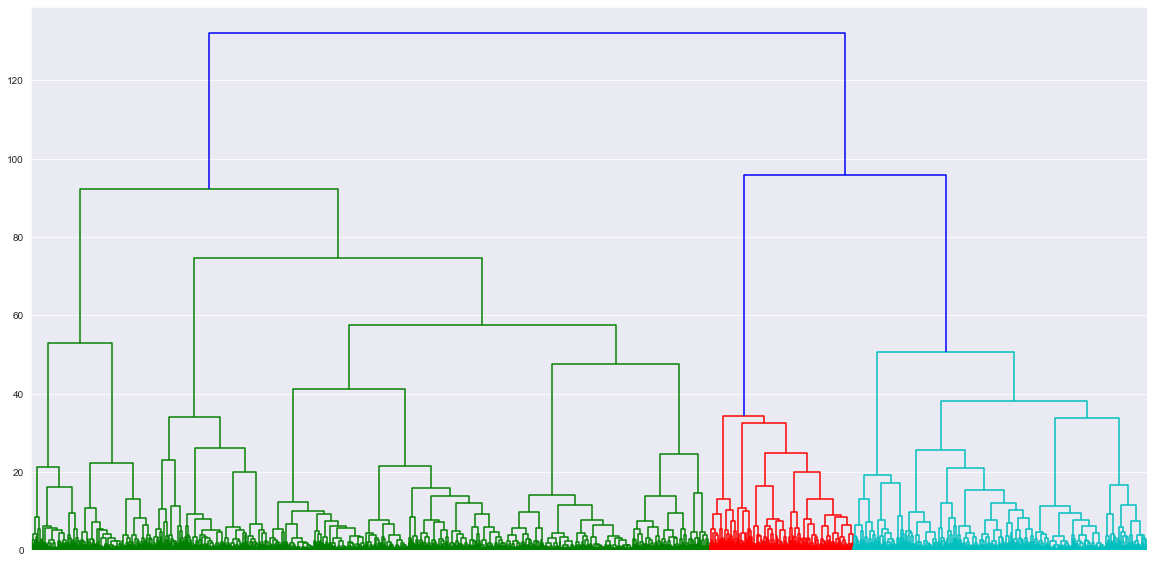

In [1095]:
from scipy.cluster.hierarchy import dendrogram, linkage
fig, ax = plt.subplots(figsize=(20,10))
Z = linkage(pca_components,method='ward', metric='euclidean')
dendrogram(Z, leaf_rotation=90,ax=ax,no_labels=True);

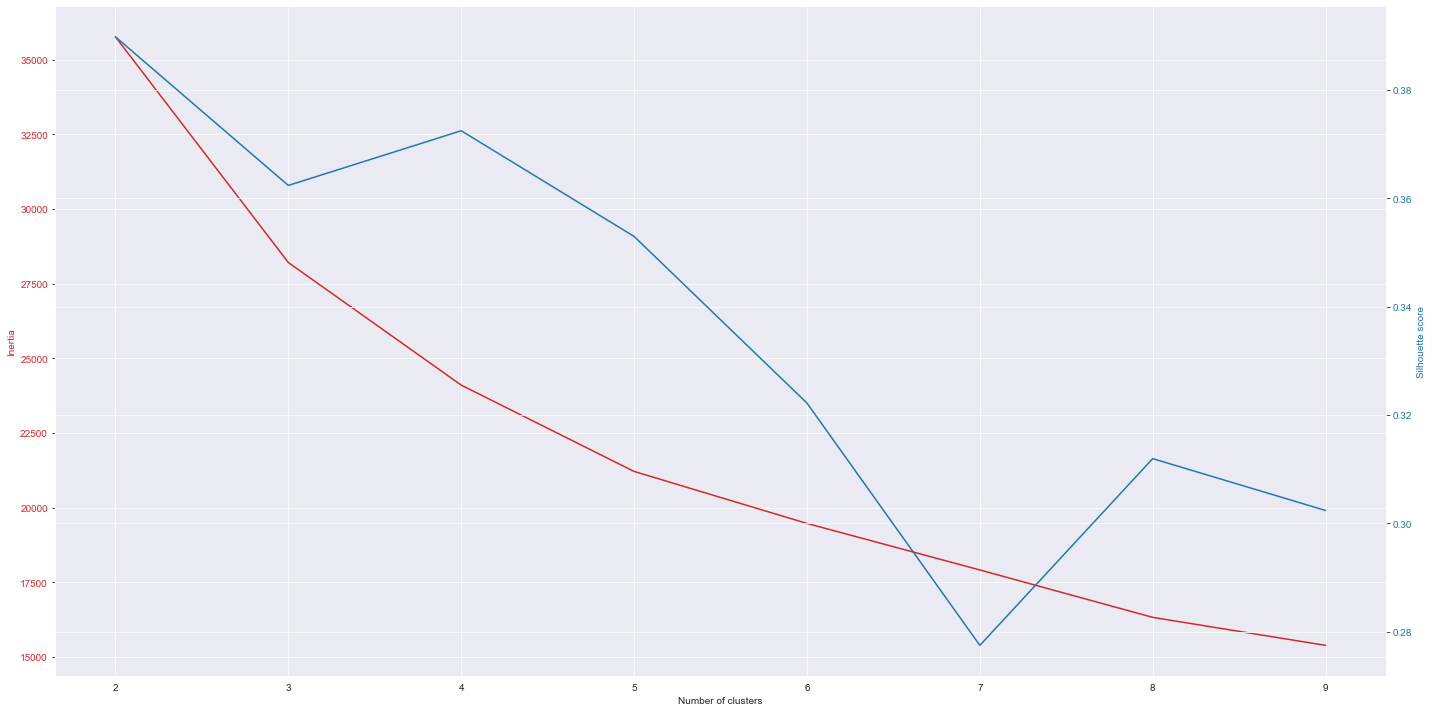

In [1143]:
distortions = []
silhouette_scores = []
with tqdm(total=len(range(2,10))) as pbar:
    for k in range(2,10):
        k_estimator = KMeans(n_clusters=k, random_state=42)
        fitted = k_estimator.fit_predict(pca_components)
        distortions.append(k_estimator.inertia_)
        silhouette_scores.append(silhouette_score(pca_components,fitted))
        pbar.update(1)


fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(range(2,10), distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Silhouette score', color=color)  
ax2.plot(range(2,10), silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()


In [1307]:
k_estimator = KMeans(n_clusters=4, random_state=42)
fitted = k_estimator.fit_predict(pca_components)

In [1308]:
pca_components['CLUSTER'] = fitted

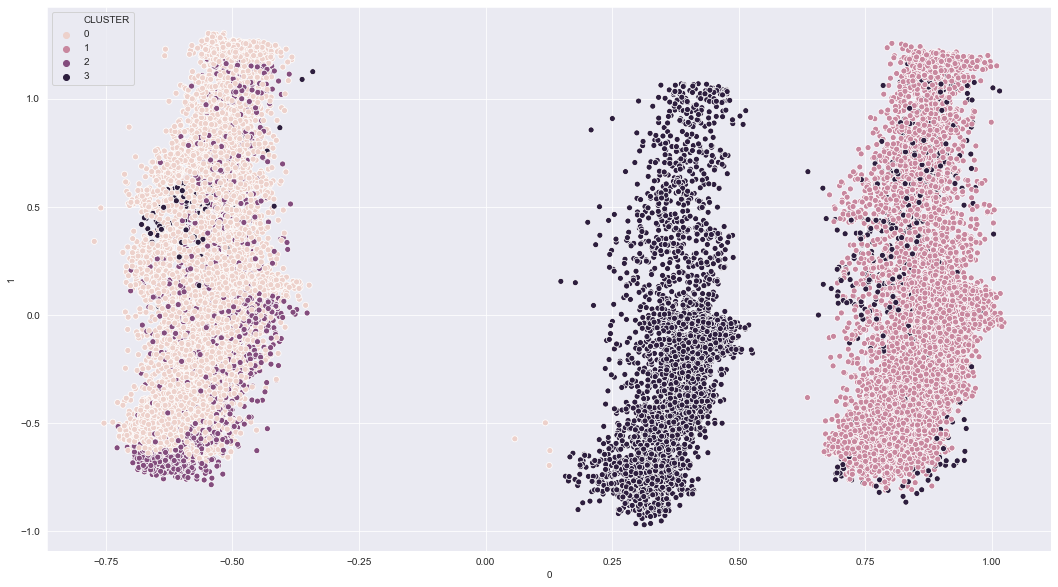

In [1309]:
fig = plt.figure(figsize=(18,10))
sns.scatterplot(pca_components[0],pca_components[1],hue=pca_components['CLUSTER']);

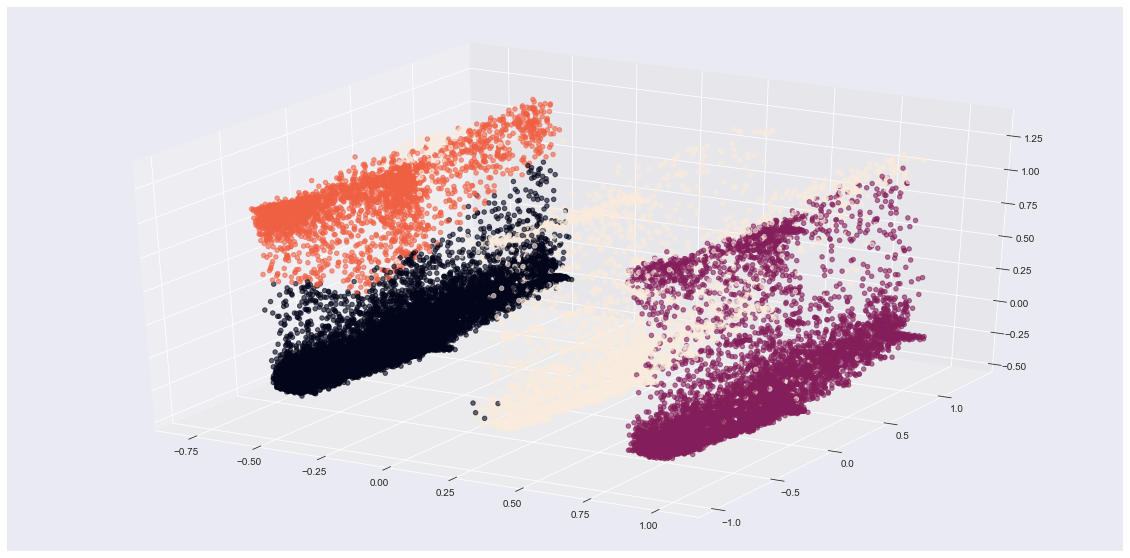

In [1310]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_components[0],pca_components[1],pca_components[2],alpha=0.6,
          c=pca_components['CLUSTER'])

plt.show()

In [1148]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

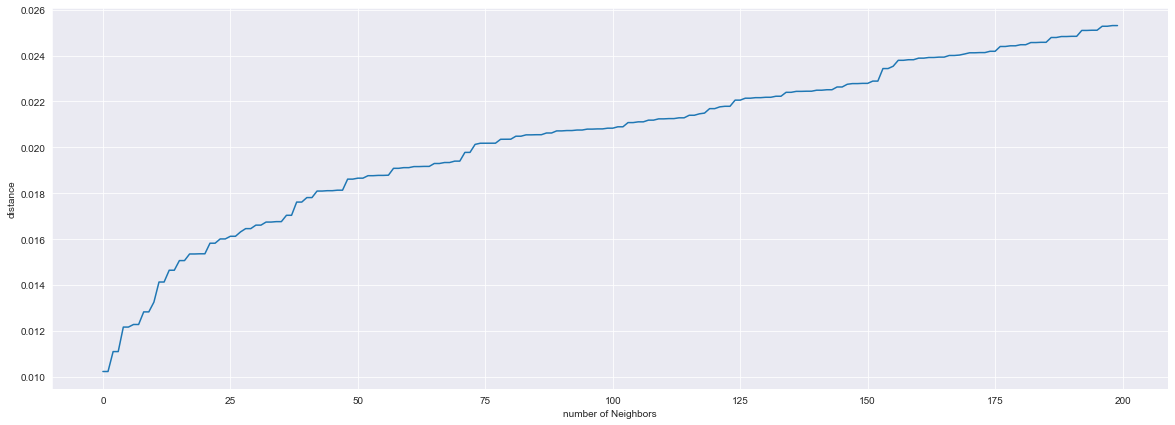

In [1149]:
neigh = NearestNeighbors(n_neighbors=5) # list of 50
nbrs = neigh.fit(pca_components)
distances, indices = nbrs.kneighbors(pca_components)
fig=plt.figure(figsize=(20,7))
distances = np.sort(distances, axis=0)
distances = distances[:,1][:200]
plt.plot(distances);
plt.xlabel('number of Neighbors')
plt.ylabel('distance')
plt.show()

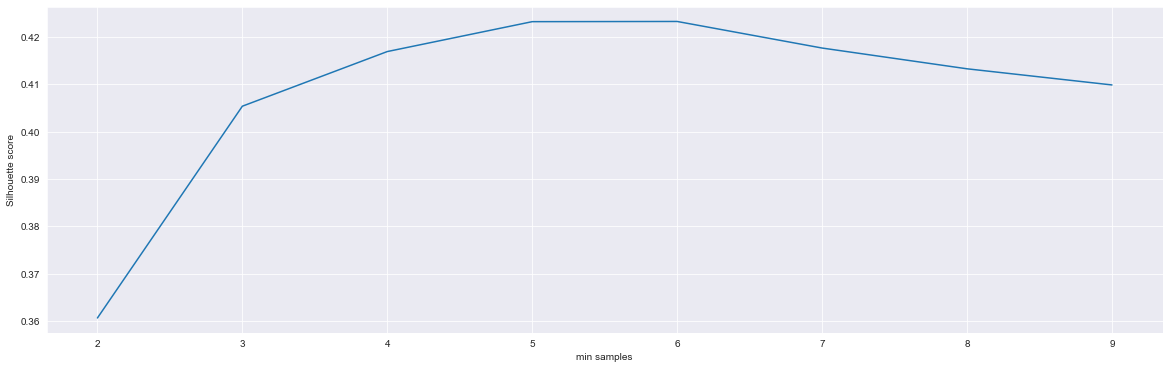

In [578]:
score = []
with tqdm(total=len(range(2,10))) as pbar:
    for n in range(5,100):
        dbs_estimator = DBSCAN(eps=0.5, min_samples=n)
        dbs_estimator.fit(pca_components)
        dbs_labels = dbs_estimator.labels_
        score.append(silhouette_score(pca_components,dbs_labels))
        pbar.update(1)
fig=plt.figure(figsize=(20,6))
plt.plot(range(2,10),score)
plt.xlabel('min samples')
plt.ylabel('Silhouette score')
plt.show()


In [1292]:
dbs_estimator = DBSCAN(eps = 0.7, min_samples=250)
dbs_labels = dbs_estimator.fit_predict(pca_components)

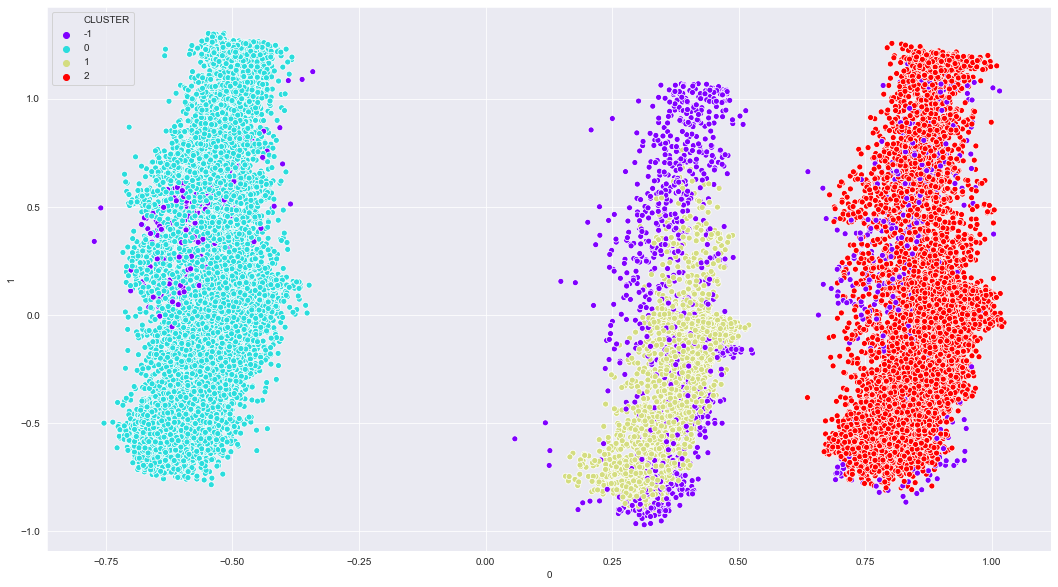

In [1293]:
pca_components['CLUSTER'] = dbs_labels
fig = plt.figure(figsize=(18,10))
sns.scatterplot(pca_components[0],pca_components[1],hue=pca_components['CLUSTER'],
               palette='rainbow');

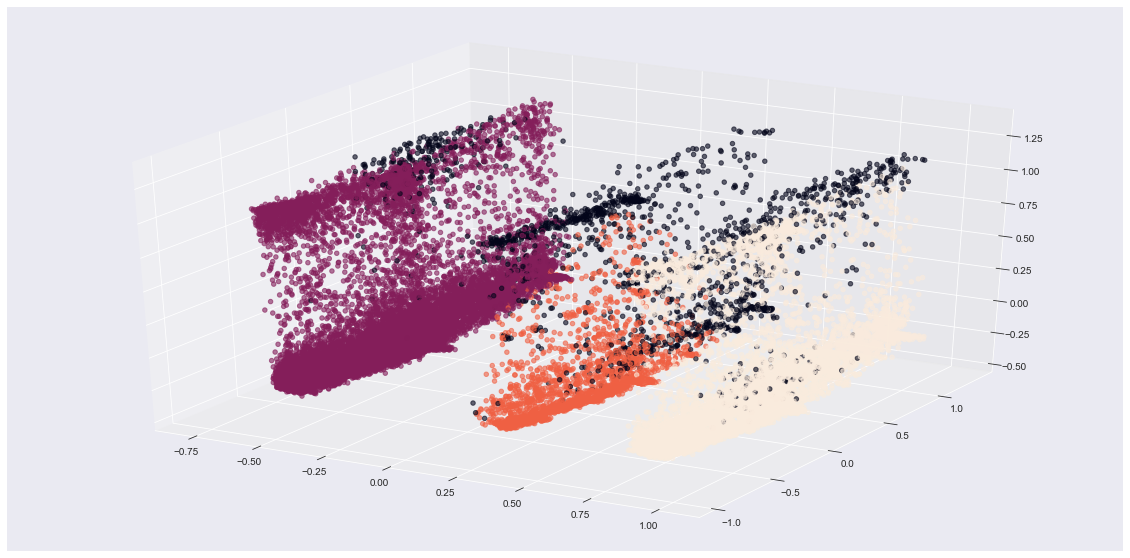

In [1294]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_components[0],pca_components[1],pca_components[2],alpha=0.6,
          c=pca_components['CLUSTER'])

plt.show()

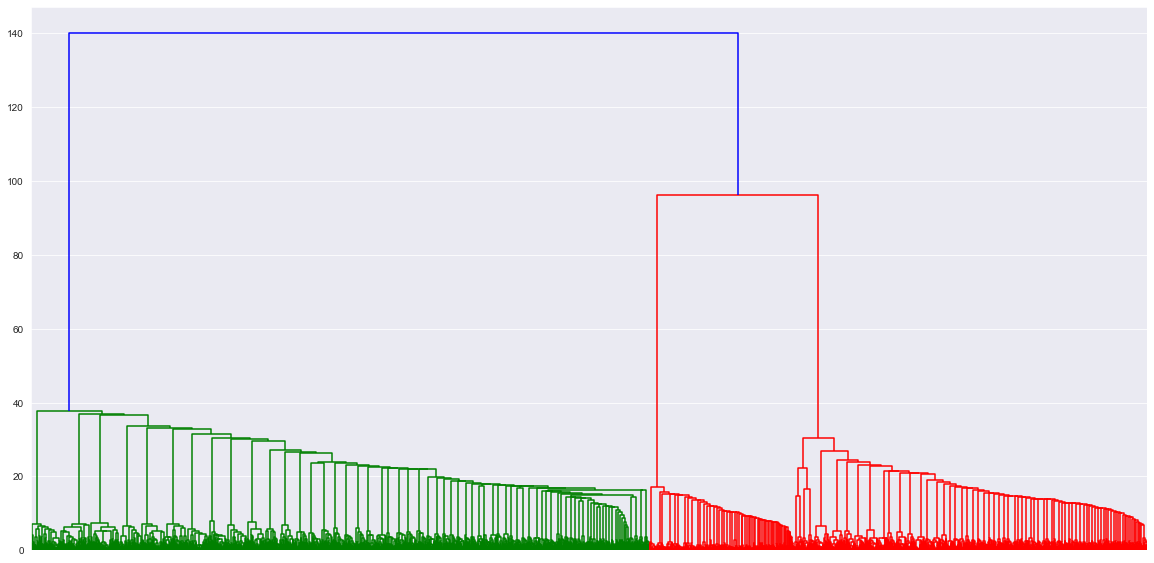

In [673]:
from scipy.cluster.hierarchy import dendrogram, linkage
fig, ax = plt.subplots(figsize=(20,10))
Z = linkage(pca_components,method='ward', metric='euclidean')
dendrogram(Z, leaf_rotation=90,ax=ax,no_labels=True);

In [1003]:
customers.index = clients
sns

avg_expense  tot_expense  CASH  CHECK  CREDIT CARD  DEBIT CARD  \
AA00312188    36.702000       917.55  22.0    0.0          0.0         3.0   
AA00312390    15.730000       471.90  30.0    0.0          0.0         0.0   
AA00325975    39.897143      1396.40   1.0    0.0          0.0        34.0   
AA00336843    21.643182       476.15  17.0    0.0          0.0         5.0   
AA00339761    29.414706       500.05  17.0    0.0          0.0         0.0   
...                 ...          ...   ...    ...          ...         ...   
YZ04556116    23.500000        47.00   2.0    0.0          0.0         0.0   
YZ04586406    54.246667       813.70  15.0    0.0          0.0         0.0   
YZ04658257    89.163636       980.80   0.0    0.0         11.0         0.0   
YZ04743693    17.620000        88.10   5.0    0.0          0.0         0.0   
YZ04933987    67.400000       337.00   0.0    0.0          5.0         0.0   

            GIFT CARD  Preferred_Outlet  0.0   1.0  ...   9.0  10.0  11.0  \
AA00312188        0.0              64.0  0.0   5.0  ...   6.0  24.0   3.0   
AA00312390        0.0              91.0  0.0   8.0  ...  17.0   8.0   0.0   
AA00325975        0.0               7.0  0.0  65.0  ...  16.0  27.0   8.0   
AA00336843        0.0               6.0  0.0   9.0  ...   6.0  15.0   1.0   
AA00339761        0.0               7.0  0.0  15.0  ...   1.0  24.0   0.0   
...               ...               ...  ...   ...  ...   ...   ...   ...   
YZ04556116        0.0               0.0  0.0   3.0  ...   0.0   0.0   0.0   
YZ04586406        0.0               0.0  0.0  20.0  ...   3.0  19.0   1.0   
YZ04658257        0.0               0.0  0.0  12.0  ...  10.0  18.0   5.0   
YZ04743693        0.0               0.0  0.0   1.0  ...   1.0   1.0   2.0   
YZ04933987        0.0               0.0  0.0   4.0  ...   7.0   8.0   4.0   

            12.0  13.0  15.0  16.0  17.0  REGIONAL_CODE  CLUSTER  
AA00312188   3.0   6.0   0.0   1.0   2.0             11        9  
AA00312390   0.0   2.0   0.0   0.0   0.0             42        6  
AA00325975   4.0   0.0   0.0   4.0   0.0             11        7  
AA00336843   2.0   0.0   0.0   1.0   0.0             11        6  
AA00339761   2.0   0.0   0.0   0.0   0.0              6        6  
...          ...   ...   ...   ...   ...            ...      ...  
YZ04556116   0.0   0.0   2.0   1.0   0.0             46        0  
YZ04586406   0.0   2.0   0.0   1.0   0.0             23        9  
YZ04658257   5.0   4.0   0.0   4.0   0.0             26        1  
YZ04743693   1.0   0.0   0.0   3.0   0.0              3        0  
YZ04933987   0.0   0.0   0.0   5.0   0.0             66       12  

[25727 rows x 25 columns]

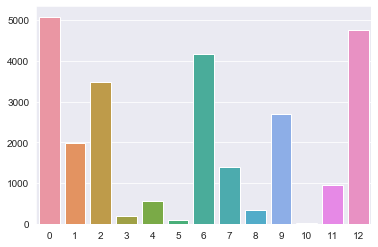

In [1005]:
sns.barplot(customers.CLUSTER.value_counts().index
        ,customers.CLUSTER.value_counts().values)

In [1035]:
where(customers,'CLUSTER',10)[13]

AL00985338     46.0
FG00405885      2.0
HV01018377      1.0
II01108783     41.0
LM00361906      0.0
LT01053024      3.0
NO00992764      0.0
NQ01316015    110.0
OV00324640      8.0
SD01121585     15.0
US00402422     56.0
WX00324265     20.0
Name: 13.0, dtype: float64

In [999]:
customers.index=range(len(customers))

In [1000]:
customers['CLUSTER'] = customers.index.map(pca_components.set_index(pca_components.index)['CLUSTER'])

In [1002]:
customers

avg_expense  tot_expense  CASH  CHECK  CREDIT CARD  DEBIT CARD  \
0        36.702000       917.55  22.0    0.0          0.0         3.0   
1        15.730000       471.90  30.0    0.0          0.0         0.0   
2        39.897143      1396.40   1.0    0.0          0.0        34.0   
3        21.643182       476.15  17.0    0.0          0.0         5.0   
4        29.414706       500.05  17.0    0.0          0.0         0.0   
...            ...          ...   ...    ...          ...         ...   
25722    23.500000        47.00   2.0    0.0          0.0         0.0   
25723    54.246667       813.70  15.0    0.0          0.0         0.0   
25724    89.163636       980.80   0.0    0.0         11.0         0.0   
25725    17.620000        88.10   5.0    0.0          0.0         0.0   
25726    67.400000       337.00   0.0    0.0          5.0         0.0   

       GIFT CARD  Preferred_Outlet  0.0   1.0  ...   9.0  10.0  11.0  12.0  \
0            0.0              64.0  0.0   5.0  ...   6.0  24.0   3.0   3.0   
1            0.0              91.0  0.0   8.0  ...  17.0   8.0   0.0   0.0   
2            0.0               7.0  0.0  65.0  ...  16.0  27.0   8.0   4.0   
3            0.0               6.0  0.0   9.0  ...   6.0  15.0   1.0   2.0   
4            0.0               7.0  0.0  15.0  ...   1.0  24.0   0.0   2.0   
...          ...               ...  ...   ...  ...   ...   ...   ...   ...   
25722        0.0               0.0  0.0   3.0  ...   0.0   0.0   0.0   0.0   
25723        0.0               0.0  0.0  20.0  ...   3.0  19.0   1.0   0.0   
25724        0.0               0.0  0.0  12.0  ...  10.0  18.0   5.0   5.0   
25725        0.0               0.0  0.0   1.0  ...   1.0   1.0   2.0   1.0   
25726        0.0               0.0  0.0   4.0  ...   7.0   8.0   4.0   0.0   

       13.0  15.0  16.0  17.0  REGIONAL_CODE  CLUSTER  
0       6.0   0.0   1.0   2.0             11        9  
1       2.0   0.0   0.0   0.0             42        6  
2       0.0   0.0   4.0   0.0             11        7  
3       0.0   0.0   1.0   0.0             11        6  
4       0.0   0.0   0.0   0.0              6        6  
...     ...   ...   ...   ...            ...      ...  
25722   0.0   2.0   1.0   0.0             46        0  
25723   2.0   0.0   1.0   0.0             23        9  
25724   4.0   0.0   4.0   0.0             26        1  
25725   0.0   0.0   3.0   0.0              3        0  
25726   0.0   0.0   5.0   0.0             66       12  

[25727 rows x 25 columns]

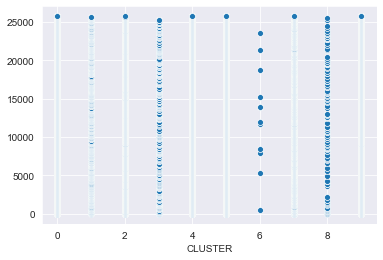

In [959]:
sns.scatterplot(customers.CLUSTER,customers.index)

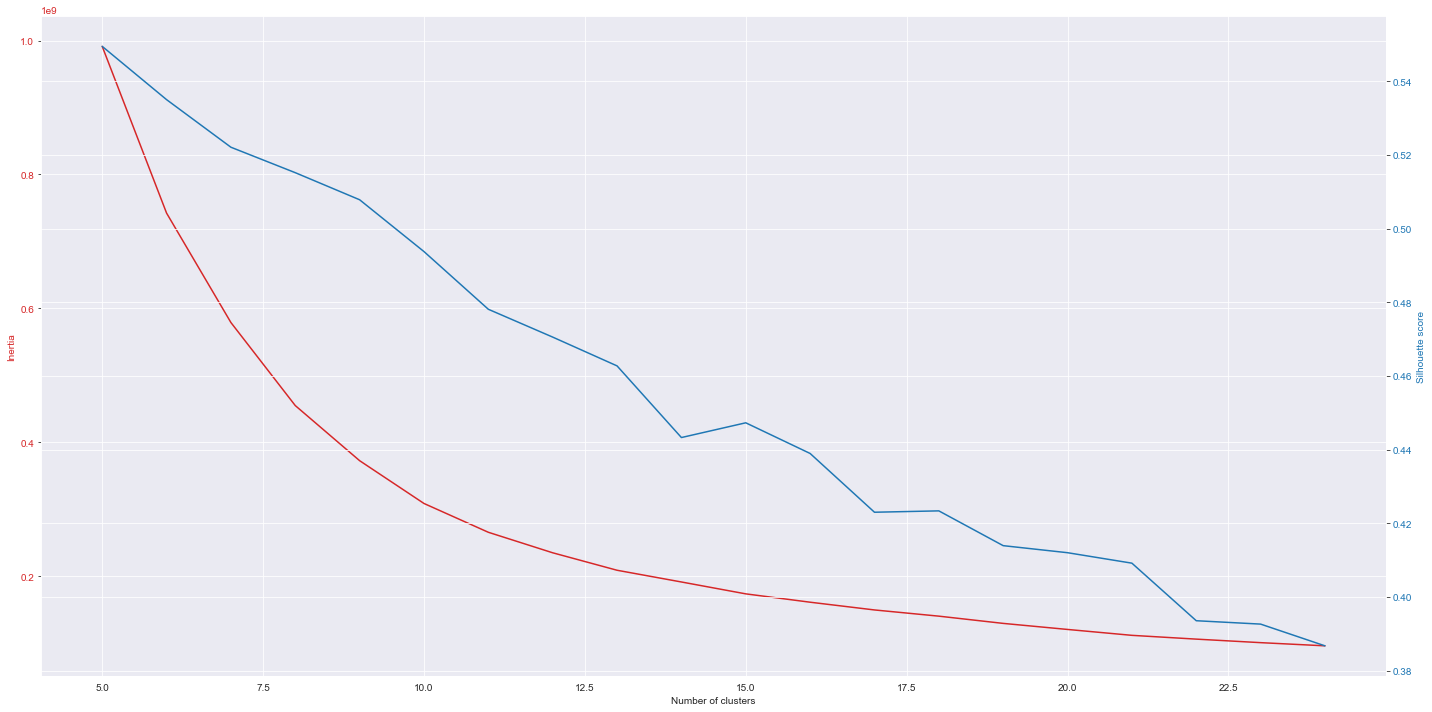

In [325]:
distortions = []
silhouette_scores = []
with tqdm(total=len(range(5,25))) as pbar:
    for k in range(5,25):
        k_estimator = KMeans(n_clusters=k, random_state=42)
        fitted = k_estimator.fit_predict(pca_components)
        distortions.append(k_estimator.inertia_)
        silhouette_scores.append(silhouette_score(pca_components,fitted))
        pbar.update(1)


fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(range(5,25), distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Silhouette score', color=color)  
ax2.plot(range(5,25), silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()


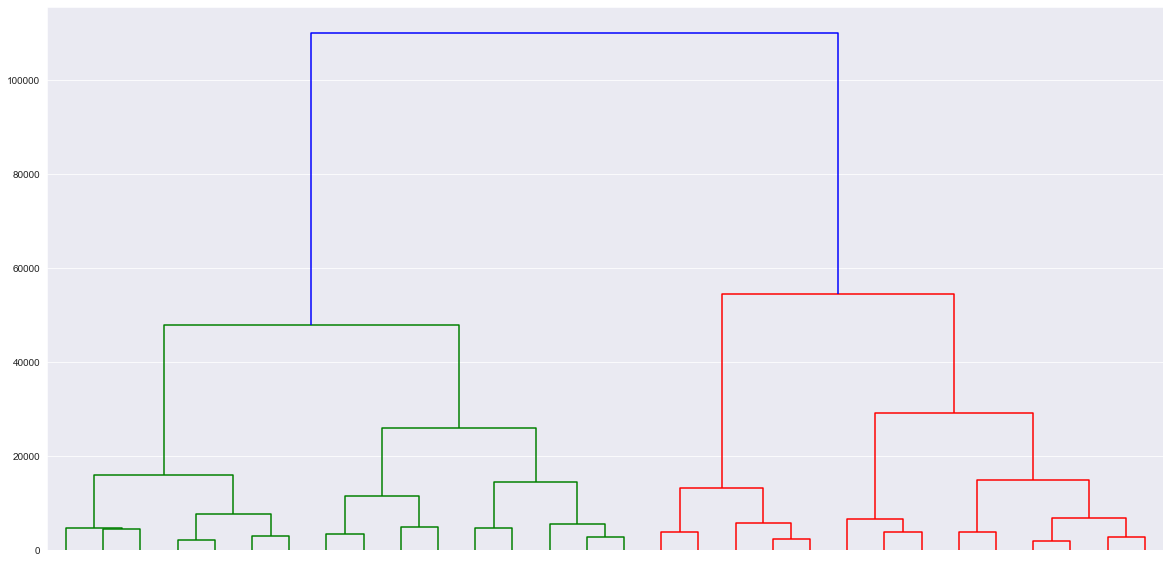

In [324]:
from scipy.cluster.hierarchy import dendrogram, linkage
fig, ax = plt.subplots(figsize=(20,10))
Z = linkage(pca_components,method='ward', metric='euclidean')
dendrogram(Z,truncate_mode='lastp', leaf_rotation=90,ax=ax,no_labels=True);

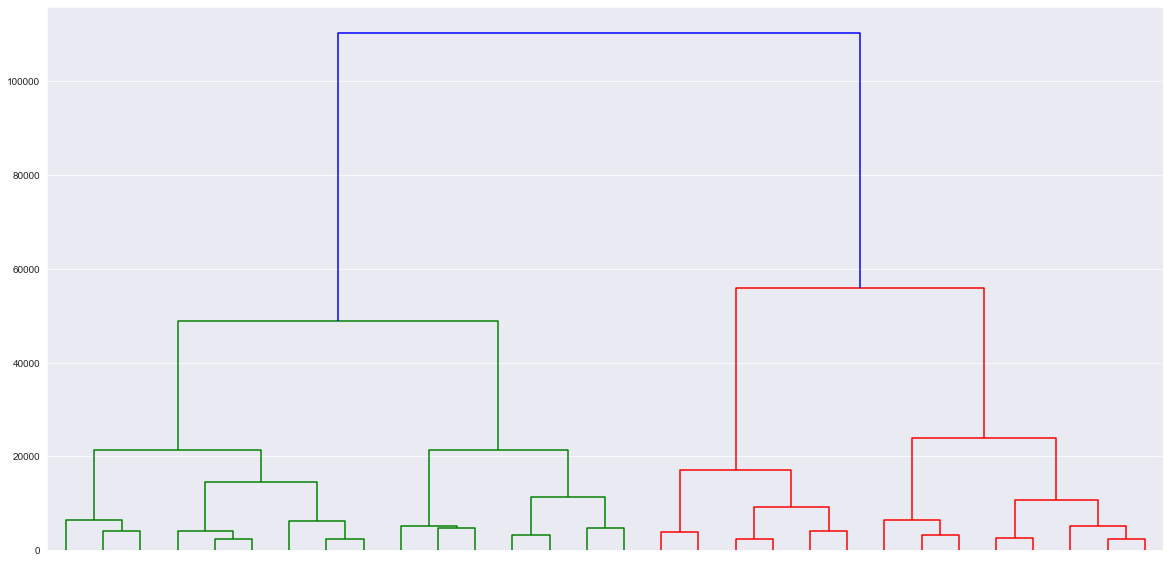

In [328]:
from scipy.cluster.hierarchy import dendrogram, linkage
fig, ax = plt.subplots(figsize=(20,10))
Z = linkage(to_pca,method='ward', metric='euclidean')
dendrogram(Z,truncate_mode='lastp', leaf_rotation=90,ax=ax,no_labels=True);

### DBSCAN

In [332]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

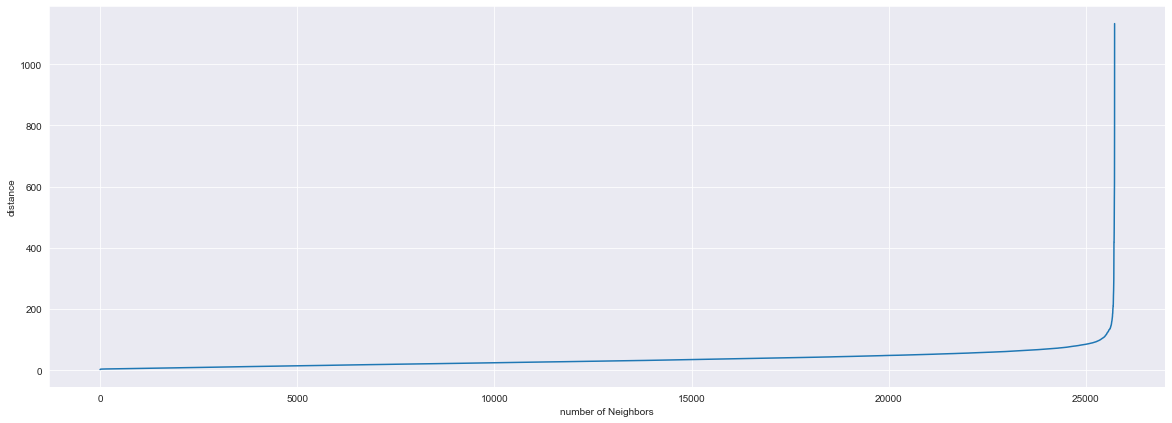

In [336]:
neigh = NearestNeighbors(n_neighbors=1050) # list of 50
nbrs = neigh.fit(to_pca)
distances, indices = nbrs.kneighbors(to_pca)
fig=plt.figure(figsize=(20,7))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances);
plt.xlabel('number of Neighbors')
plt.ylabel('distance')
plt.show()

In [363]:
k_estimator = KMeans(n_clusters=13, random_state=42)
fitted = k_estimator.fit_predict(to_pca)

In [364]:
pca_components['CLUSTER'] = fitted
customers['CLUSTER'] = fitted

In [365]:
sales_detail['CLUSTER'] = sales_detail.new_c_key.map(customers.set_index(customers.index)['CLUSTER'])

In [373]:
where(sales_detail,'CLUSTER',0).CATEGORY_ID.value_counts()

3.0     59966
10.0    34389
1.0     30380
7.0     29914
9.0     15609
4.0     13264
11.0     9539
12.0     6698
13.0     4552
6.0      3681
16.0     3442
2.0      1661
17.0      377
15.0      167
0.0        30
Name: CATEGORY_ID, dtype: int64

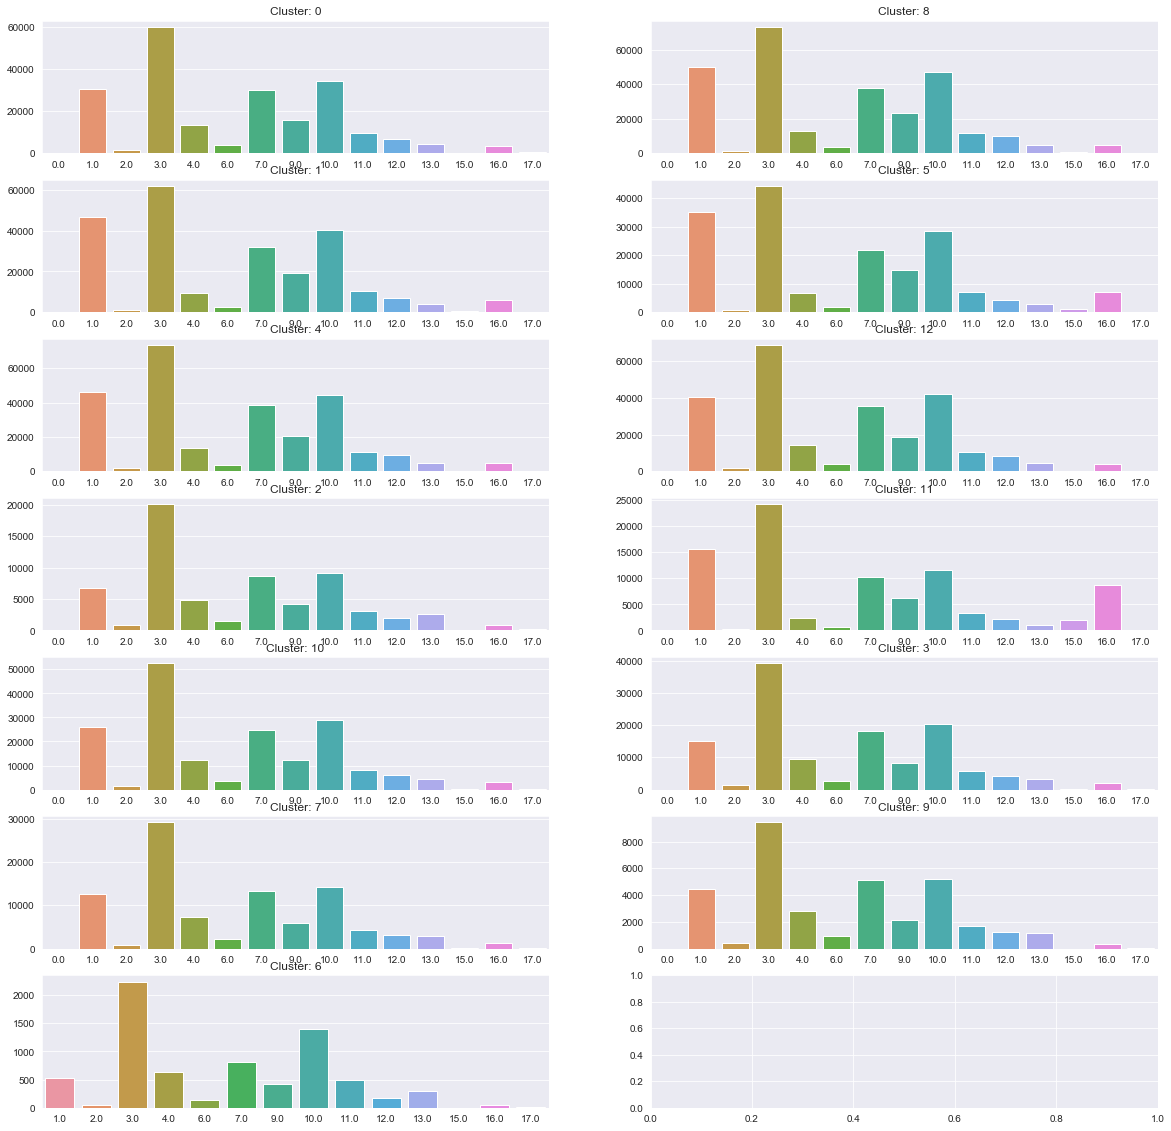

In [407]:
fig, ax = plt.subplots(figsize=(20,20), nrows=7, ncols=2)
counter = 0

for cluster in sales_detail['CLUSTER'].unique():

    j = counter%2; i = counter//2;
    indexes = where(sales_detail,'CLUSTER',cluster).OUTLET_ID.value_counts().index
    values = where(sales_detail,'CLUSTER',cluster).CATEGORY_ID.value_counts().values
    sns.barplot(indexes,values,ax=ax[i,j])
    ax[i,j].set_title('Cluster: {}'.format(cluster))
    counter+=1


In [409]:
sales['CLUSTER'] = sales.new_c_key.map(customers.set_index(customers.index)['CLUSTER'])

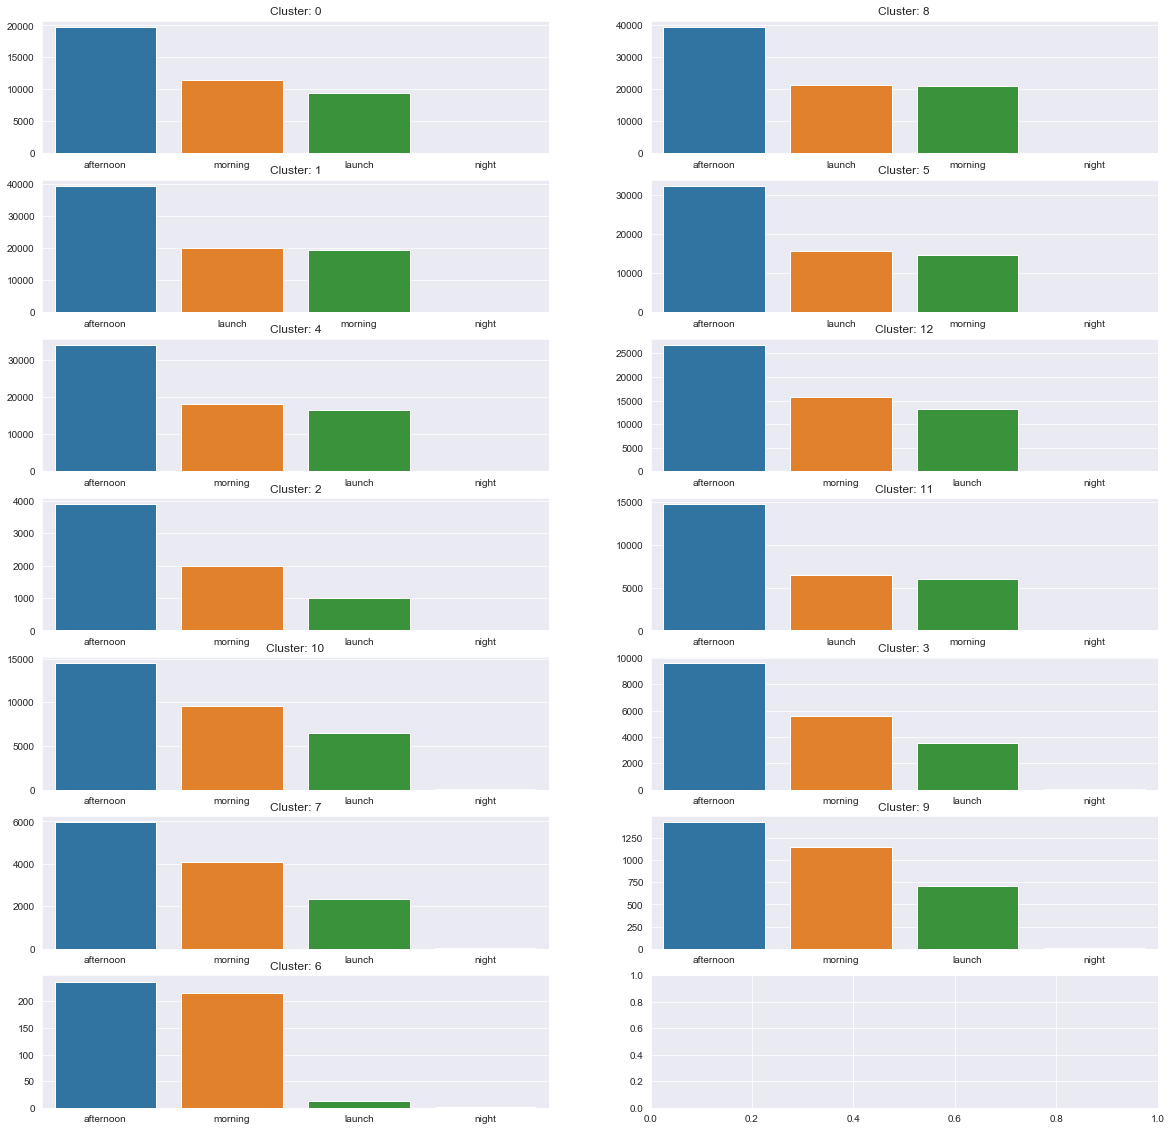

In [416]:
fig, ax = plt.subplots(figsize=(20,20), nrows=7, ncols=2)
counter = 0

for cluster in sales['CLUSTER'].unique():

    j = counter%2; i = counter//2;
    array = where(sales,'CLUSTER',cluster).orario.value_counts()
    sns.barplot(array.index,array.values,ax=ax[i,j])
    ax[i,j].set_title('Cluster: {}'.format(cluster))
    counter+=1


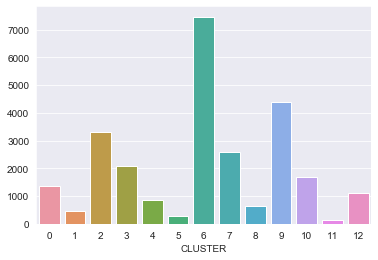

In [424]:
sns.barplot(customers.groupby('CLUSTER').mean().index,
           customers.groupby('CLUSTER').mean().tot_expense.values)

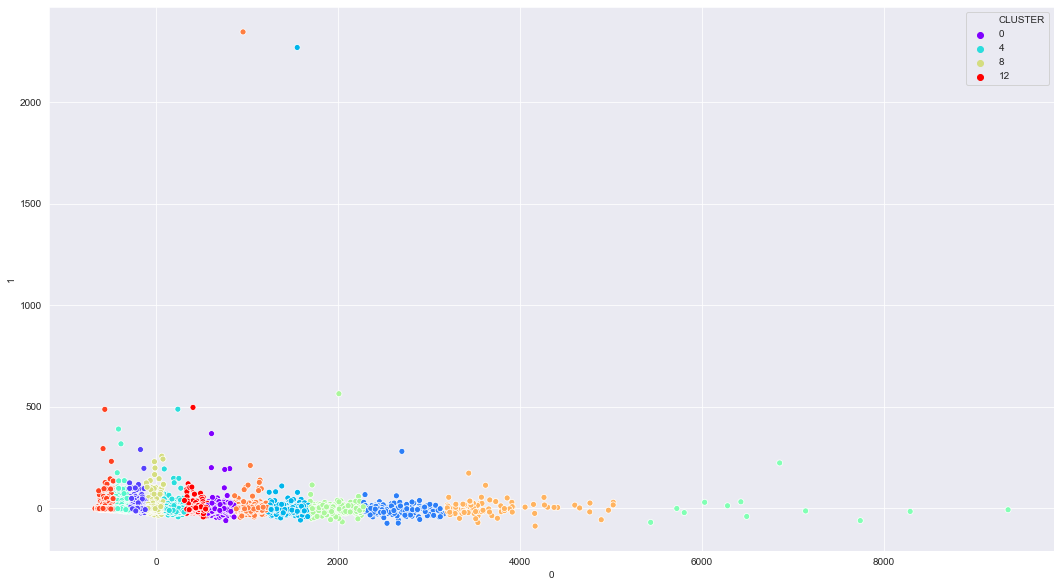

In [430]:
fig = plt.figure(figsize=(18,10))
sns.scatterplot(pca_components[0],pca_components[1],hue=pca_components['CLUSTER'],
               palette='rainbow');

In [425]:
sales

CUSTOMER_ID       DATE  OUTLET_ID PAYMENT_METHOD      TIME  \
0       AA00325975 2018-06-30          7     DEBIT CARD  11:28:16   
1       AA01053942 2018-06-30         25    CREDIT CARD  16:41:37   
2       AA01393171 2018-06-30         64    CREDIT CARD  13:33:32   
3       AB01053149 2018-06-30         95     DEBIT CARD  10:19:54   
4       AB01973926 2018-06-30         81     DEBIT CARD  12:15:21   
...            ...        ...        ...            ...       ...   
488934  YG01213021 2020-01-26         10           CASH  14:41:13   
488935  YI00811425 2020-01-26         87    CREDIT CARD  12:45:15   
488936  YO01393043 2020-01-26         89    CREDIT CARD  12:11:35   
488937  YQ02154745 2020-01-26         29           CASH  10:45:05   
488938  YV00655597 2020-01-26         18    CREDIT CARD  10:37:25   

        TOTAL_POINTS                 f_key  Expense  ITEMS  day_of_week  WEEK  \
0              220.0  AA003259752018-06-30    27.50    4.0          5.0   0.0   
1              615.0  AA010539422018-06-30    78.20   10.0          5.0   0.0   
2               90.0  AA013931712018-06-30    13.90    2.0          5.0   0.0   
3              425.0  AB010531492018-06-30    57.00    6.0          5.0   0.0   
4              280.0  AB019739262018-06-30    36.35    7.0          5.0   0.0   
...              ...                   ...      ...    ...          ...   ...   
488934         895.0  YG012130212020-01-26    64.20   10.0          6.0  82.0   
488935           0.0  YI008114252020-01-26    13.95    1.0          6.0  82.0   
488936        1600.0  YO013930432020-01-26   102.10   20.0          6.0  82.0   
488937       -1915.0  YQ021547452020-01-26    33.30    6.0          6.0  82.0   
488938         600.0  YV006555972020-01-26    38.80    4.0          6.0  82.0   

        new_c_key     orario  CLUSTER  
0               2    morning        0  
1              22  afternoon        8  
2              29     launch        0  
3              71    morning        0  
4              77     launch        1  
...           ...        ...      ...  
488934      24961  afternoon       10  
488935      25025     launch       11  
488936      25272     launch        9  
488937      25357    morning        8  
488938      25555    morning        8  

[488939 rows x 14 columns]

In [90]:
Itemsets=np.array([])
Itemsets = np.append(Itemsets,'col')
Itemsets

array(['col'], dtype='<U32')

In [92]:
sales_detail['OUTLET_ID'] = sales_detail.f_key.map(sales.set_index('f_key')['OUTLET_ID'])

In [93]:
sales_detail

CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL  \
0        AA00325975  2018-06-30         348       1.0        5.75       N   
1        AA00325975  2018-06-30         636       1.0        5.45       N   
2        AA00325975  2018-06-30       97741       1.0        6.35       N   
3        AA00325975  2018-06-30        2594       1.0        9.95       N   
4        AA01053942  2018-06-30       17356       1.0        6.65       N   
...             ...         ...         ...       ...         ...     ...   
2047055  YQ02154745  2020-01-26      246797       1.0        4.45       N   
2047056  YQ02154745  2020-01-26       12012       1.0        5.25       N   
2047057  YV00655597  2020-01-26      111867       1.0       11.45       N   
2047058  YV00655597  2020-01-26      130700       1.0        7.45       N   
2047059  YV00655597  2020-01-26      243446       2.0       19.90       N   

         unit_price  CATEGORY_ID                 f_key  OUTLET_ID  
0              5.75          1.0  AA003259752018-06-30        7.0  
1              5.45          1.0  AA003259752018-06-30        7.0  
2              6.35          3.0  AA003259752018-06-30        7.0  
3              9.95          7.0  AA003259752018-06-30        7.0  
4              6.65          3.0  AA010539422018-06-30       25.0  
...             ...          ...                   ...        ...  
2047055        4.45          3.0  YQ021547452020-01-26       29.0  
2047056        5.25         13.0  YQ021547452020-01-26       29.0  
2047057       11.45          3.0  YV006555972020-01-26       18.0  
2047058        7.45          3.0  YV006555972020-01-26       18.0  
2047059        9.95          4.0  YV006555972020-01-26       18.0  

[2047060 rows x 10 columns]

In [94]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [138]:
p_o = sales_detail[['PRODUCT_ID','OUTLET_ID']]
f_key = p_o.PRODUCT_ID.astype(str) + '_' + p_o.OUTLET_ID.values.astype(str)
p_o['f_key'] = f_key
p_o_view = p_o.groupby('f_key').mean()
p_o_view

/Users/pierfrancescomelucci/opt/anaconda3/envs/ENV/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


PRODUCT_ID  OUTLET_ID
f_key                            
-12_10.0           -12       10.0
-12_100.0          -12      100.0
-12_101.0          -12      101.0
-12_102.0          -12      102.0
-12_103.0          -12      103.0
...                ...        ...
98894_95.0       98894       95.0
98894_96.0       98894       96.0
98894_97.0       98894       97.0
98894_98.0       98894       98.0
98894_99.0       98894       99.0

[84211 rows x 2 columns]

In [105]:
p_o = p_o.fillna(-1)

In [106]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import decomposition

Evaluating for 2
Evaluating for 3
Evaluating for 4
Evaluating for 5
Evaluating for 6
Evaluating for 7
Evaluating for 8
Evaluating for 9
Evaluating for 10
Evaluating for 11
Evaluating for 12
Evaluating for 13
Evaluating for 14
Evaluating for 15
Evaluating for 16
Evaluating for 17
Evaluating for 18
Evaluating for 19
Evaluating for 20
Evaluating for 21
Evaluating for 22
Evaluating for 23
Evaluating for 24
Evaluating for 25
Evaluating for 26
Evaluating for 27
Evaluating for 28
Evaluating for 29
Evaluating for 30
Evaluating for 31
Evaluating for 32
Evaluating for 33
Evaluating for 34
Evaluating for 35
Evaluating for 36
Evaluating for 37
Evaluating for 38
Evaluating for 39


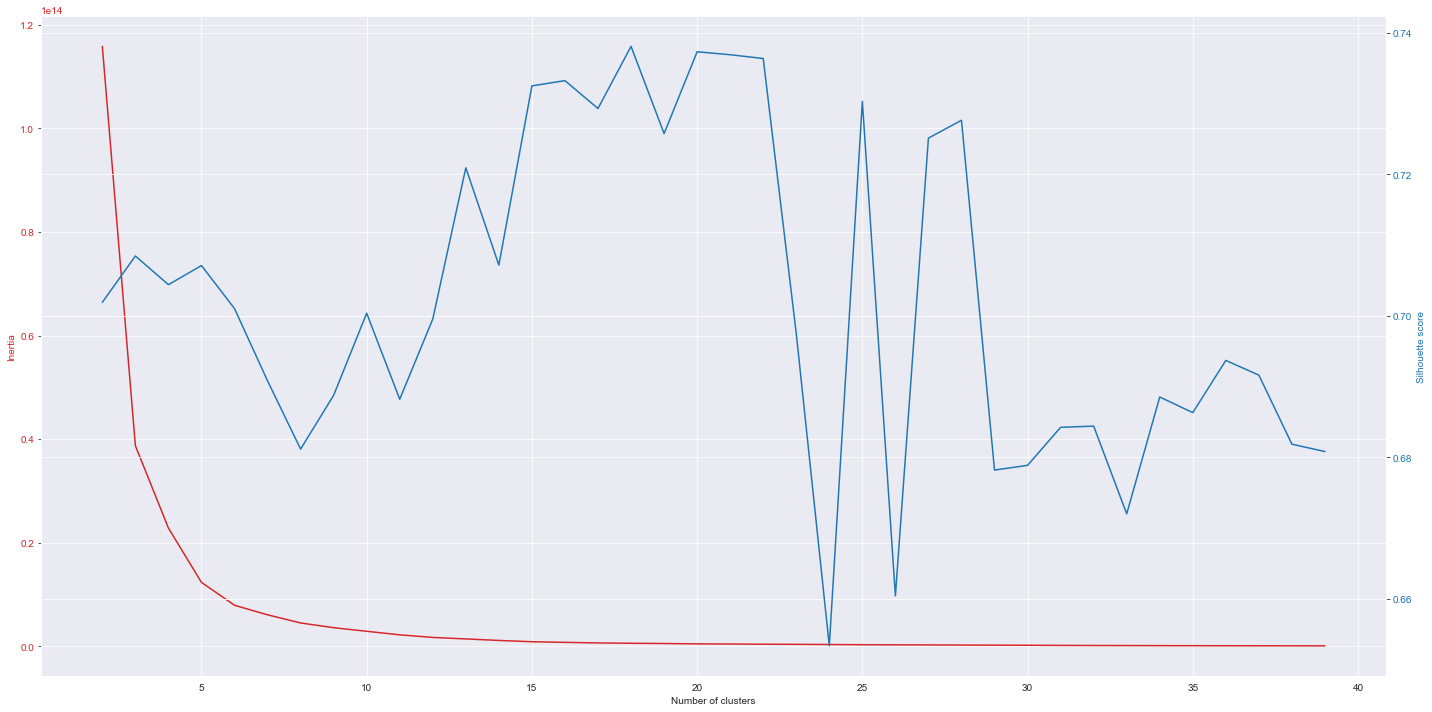

In [108]:
distortions = []
silhouette_scores = []
for k in range(2,40):
    print('Evaluating for {}'.format(k))
    k_estimator = KMeans(n_clusters=k, random_state=42)
    fitted = k_estimator.fit_predict(p_o)
    distortions.append(k_estimator.inertia_)
    silhouette_scores.append(silhouette_score(p_o,fitted))


fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(range(2,40), distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Silhouette score', color=color)  
ax2.plot(range(2,40), silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()


In [109]:
k_estimator = KMeans(n_clusters=10, random_state=42)
fitted = k_estimator.fit_predict(p_o)
silhouette_score(p_o,fitted)

0.7003924658514944

In [113]:
p_o['CLUSTER'] = fitted
p_o

PRODUCT_ID  OUTLET_ID  CLUSTER
f_key                                     
-12_10.0           -12       10.0        0
-12_100.0          -12      100.0        0
-12_101.0          -12      101.0        0
-12_102.0          -12      102.0        0
-12_103.0          -12      103.0        0
...                ...        ...      ...
98894_95.0       98894       95.0        2
98894_96.0       98894       96.0        2
98894_97.0       98894       97.0        2
98894_98.0       98894       98.0        2
98894_99.0       98894       99.0        2

[84211 rows x 3 columns]

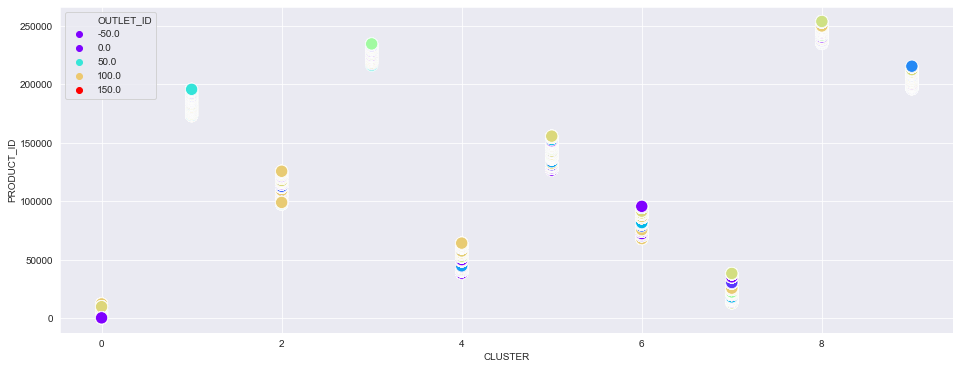

In [133]:
fig = plt.figure(figsize=(16,6))
sns.scatterplot(p_o.CLUSTER,p_o.PRODUCT_ID,hue=p_o.OUTLET_ID,s=150,palette='rainbow');

In [137]:
p_o[p_o.OUTLET_ID == 101].CLUSTER.value_counts()

0    158
5    126
1     80
2     63
8     46
7     44
4     44
9     39
3     39
6     25
Name: CLUSTER, dtype: int64

In [474]:
p_o = sales_detail[['PRODUCT_ID','CATEGORY_ID','OUTLET_ID']]
f_key = p_o.OUTLET_ID.values.astype(str) + p_o.CATEGORY_ID.astype(str) + '_' + p_o.PRODUCT_ID.astype(str) 
p_o['f_key'] = f_key
p_o_view = p_o.groupby('f_key').mean()
p_o_view = p_o_view.fillna(143)
p_o_view

/Users/pierfrancescomelucci/opt/anaconda3/envs/ENV/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


PRODUCT_ID  CATEGORY_ID  OUTLET_ID
f_key                                            
0.01.0_112107      112107          1.0        0.0
0.01.0_112131      112131          1.0        0.0
0.01.0_112155      112155          1.0        0.0
0.01.0_117403      117403          1.0        0.0
0.01.0_121489      121489          1.0        0.0
...                   ...          ...        ...
nan9.0_3062          3062          9.0      143.0
nan9.0_3098          3098          9.0      143.0
nan9.0_3110          3110          9.0      143.0
nan9.0_44310        44310          9.0      143.0
nan9.0_81403        81403          9.0      143.0

[84211 rows x 3 columns]

In [506]:
p_o_view

PRODUCT_ID  CATEGORY_ID  OUTLET_ID
f_key                                            
0.01.0_112107      112107          1.0        0.0
0.01.0_112131      112131          1.0        0.0
0.01.0_112155      112155          1.0        0.0
0.01.0_117403      117403          1.0        0.0
0.01.0_121489      121489          1.0        0.0
...                   ...          ...        ...
nan9.0_3062          3062          9.0      143.0
nan9.0_3098          3098          9.0      143.0
nan9.0_3110          3110          9.0      143.0
nan9.0_44310        44310          9.0      143.0
nan9.0_81403        81403          9.0      143.0

[84211 rows x 3 columns]

# create outlet table

In [534]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [535]:
#p_o_view=p_o_view.drop('CLUSTER',axis=1)

In [536]:
len(sales_detail.OUTLET_ID.unique())

131

In [537]:
p_o_view = p_o_view.fillna(143)

In [610]:
otulet_table = np.zeros((131,len(sales_detail.PRODUCT_ID.unique())))
otulet_table = pd.DataFrame(otulet_table)
#otulet_table['OUTLET_ID']=np.sort(sales_detail.OUTLET_ID.unique())
otulet_table = otulet_table.fillna(143)
otulet_table.index = np.sort(sales_detail.OUTLET_ID.unique())
otulet_table.columns = np.sort(sales_detail.PRODUCT_ID.unique())
otulet_table.index = otulet_table.index.fillna(143)
otulet_table

-12       36       60       96       144      204      216      228     \
0.0        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3.0        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4.0        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
5.0        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
6.0        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
137.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
139.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
140.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
141.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
143.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

        252      264     ...   249451   249463   249680   249920   253273  \
0.0        0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
3.0        0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
4.0        0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
5.0        0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
6.0        0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
...        ...      ...  ...      ...      ...      ...      ...      ...   
137.0      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
139.0      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
140.0      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
141.0      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
143.0      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   

        253285   253513   253525   253537   253753  
0.0        0.0      0.0      0.0      0.0      0.0  
3.0        0.0      0.0      0.0      0.0      0.0  
4.0        0.0      0.0      0.0      0.0      0.0  
5.0        0.0      0.0      0.0      0.0      0.0  
6.0        0.0      0.0      0.0      0.0      0.0  
...        ...      ...      ...      ...      ...  
137.0      0.0      0.0      0.0      0.0      0.0  
139.0      0.0      0.0      0.0      0.0      0.0  
140.0      0.0      0.0      0.0      0.0      0.0  
141.0      0.0      0.0      0.0      0.0      0.0  
143.0      0.0      0.0      0.0      0.0      0.0  

[131 rows x 1379 columns]

In [630]:
list_outlets = otulet_table.index

In [631]:
with tqdm(total=len(list_outlets)) as pbar:
    for outlet in list_outlets:
        counts = sales_detail[sales_detail.OUTLET_ID==outlet][['PRODUCT_ID','QUANTITY']].groupby('PRODUCT_ID').sum().sort_values('PRODUCT_ID',axis=0)
        indici = counts.index.values
        counts = counts.values
        j=0
        for i in indici:
            otulet_table.loc[outlet,i] = counts[j].item()
            j +=1
        pbar.update(1)





In [644]:
#otulet_table.drop(143,inplace=True)
otulet_table

-12       36       60       96       144      204      216      228     \
0.0        0.0      1.0      1.0      5.0      0.0     10.0     13.0      3.0   
3.0       13.0      5.0      7.0      7.0      0.0     50.0     14.0     33.0   
4.0        0.0      0.0      0.0      0.0      0.0      1.0      0.0      0.0   
5.0        5.0     34.0     71.0     41.0      0.0    127.0     43.0     49.0   
6.0      118.0     71.0    142.0     74.0      2.0    416.0    191.0    121.0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
136.0      0.0      1.0      1.0      2.0      0.0     10.0      1.0      7.0   
137.0      0.0      2.0      1.0      0.0      0.0      4.0      1.0      0.0   
139.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
140.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      2.0   
141.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

        252      264     ...   249451   249463   249680   249920   253273  \
0.0        9.0      0.0  ...      2.0      0.0      0.0      0.0      0.0   
3.0       18.0      0.0  ...      2.0      2.0      0.0      3.0      0.0   
4.0        0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
5.0       40.0      0.0  ...      1.0      5.0      0.0      1.0      1.0   
6.0       89.0      0.0  ...     17.0     10.0      0.0      3.0      5.0   
...        ...      ...  ...      ...      ...      ...      ...      ...   
136.0      5.0      0.0  ...      4.0      2.0      0.0      0.0      2.0   
137.0      0.0      0.0  ...      2.0      4.0      0.0      2.0      1.0   
139.0      0.0      0.0  ...      0.0      1.0      0.0      0.0      1.0   
140.0      1.0      0.0  ...      0.0      1.0      0.0      0.0      0.0   
141.0      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   

        253285   253513   253525   253537   253753  
0.0        0.0      0.0      0.0      0.0      0.0  
3.0        0.0      0.0      0.0      0.0      0.0  
4.0        0.0      0.0      0.0      0.0      0.0  
5.0        0.0      3.0      1.0      0.0      0.0  
6.0        1.0      3.0      2.0      5.0      0.0  
...        ...      ...      ...      ...      ...  
136.0      0.0      0.0      0.0      1.0      1.0  
137.0      0.0      0.0      0.0      0.0      0.0  
139.0      0.0      1.0      0.0      1.0      0.0  
140.0      0.0      0.0      0.0      1.0      0.0  
141.0      0.0      0.0      0.0      0.0      0.0  

[130 rows x 1379 columns]

Evaluating for 2 cluster
Evaluating for 3 cluster
Evaluating for 4 cluster
Evaluating for 5 cluster
Evaluating for 6 cluster
Evaluating for 7 cluster
Evaluating for 8 cluster
Evaluating for 9 cluster
Evaluating for 10 cluster
Evaluating for 11 cluster
Evaluating for 12 cluster
Evaluating for 13 cluster
Evaluating for 14 cluster
Evaluating for 15 cluster
Evaluating for 16 cluster
Evaluating for 17 cluster
Evaluating for 18 cluster
Evaluating for 19 cluster
Evaluating for 20 cluster
Evaluating for 21 cluster
Evaluating for 22 cluster
Evaluating for 23 cluster
Evaluating for 24 cluster
Evaluating for 25 cluster
Evaluating for 26 cluster
Evaluating for 27 cluster
Evaluating for 28 cluster
Evaluating for 29 cluster
Evaluating for 30 cluster
Evaluating for 31 cluster
Evaluating for 32 cluster
Evaluating for 33 cluster
Evaluating for 34 cluster
Evaluating for 35 cluster
Evaluating for 36 cluster
Evaluating for 37 cluster
Evaluating for 38 cluster
Evaluating for 39 cluster
Evaluating for 40 cl

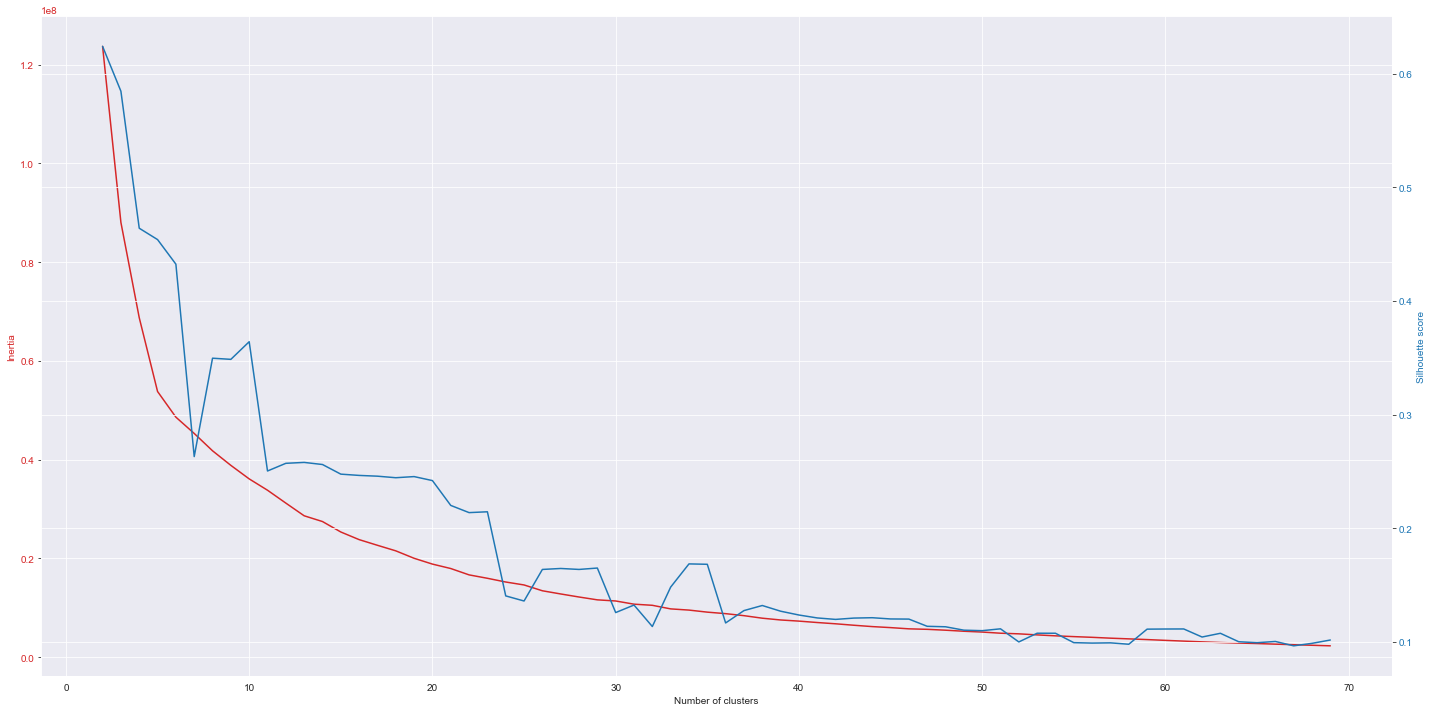

In [646]:
distortions = []
silhouette_scores = []
for k in range(2,70):
    print('Evaluating for {} cluster'.format(k))
    k_estimator = KMeans(n_clusters=k, random_state=42)
    fitted = k_estimator.fit_predict(otulet_table)
    distortions.append(k_estimator.inertia_)
    silhouette_scores.append(silhouette_score(otulet_table,fitted))


fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(range(2,70), distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Silhouette score', color=color)  
ax2.plot(range(2,70), silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [647]:
k_estimator = KMeans(n_clusters=10, random_state=42)
fitted = k_estimator.fit_predict(otulet_table)
silhouette_score(otulet_table,fitted)


0.36412869495591776

In [648]:
otulet_table['CLUSTER']=fitted


In [649]:
p_o_view['CLUSTER'] = p_o_view.OUTLET_ID.map(otulet_table.set_index(otulet_table.index)['CLUSTER'])


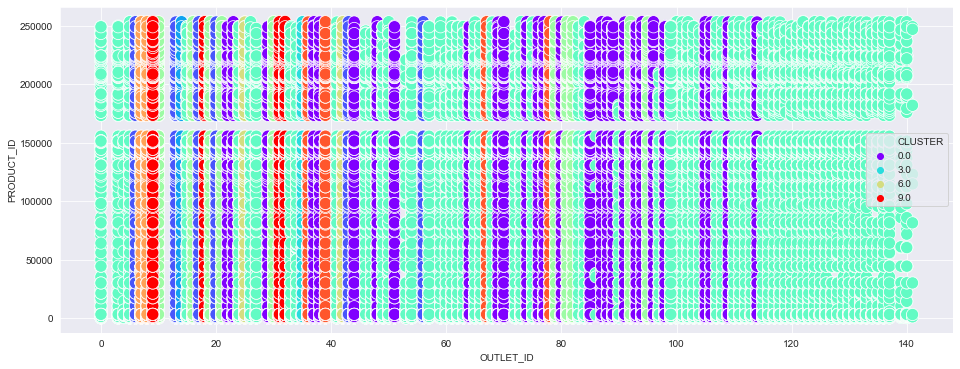

In [650]:
fig = plt.figure(figsize=(16,6))
sns.scatterplot(p_o_view.OUTLET_ID,p_o_view.PRODUCT_ID,hue=p_o_view.CLUSTER
                ,s=150,palette='rainbow');

In [651]:
otulet_table.CLUSTER.value_counts()

4    72
0    28
5    10
1     6
9     4
8     4
7     2
6     2
3     1
2     1
Name: CLUSTER, dtype: int64

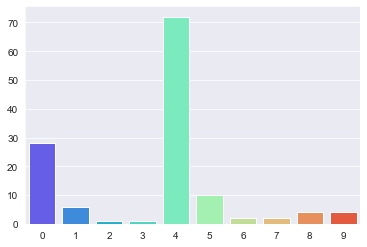

In [652]:
sns.barplot(otulet_table.CLUSTER.value_counts().index,
            otulet_table.CLUSTER.value_counts().values,
            palette='rainbow');

In [462]:
sales_detail.CUSTOMER_ID.value_counts()

LT01053024    938
OV00324640    938
HV01018377    884
FG00405885    765
AL00985338    711
             ... 
AA01100736      2
HB00858242      2
MQ03149229      2
MD04330490      2
PU03254600      1
Name: CUSTOMER_ID, Length: 25727, dtype: int64

In [653]:
sales_detail['CLUSTER'] = sales_detail.OUTLET_ID.map(otulet_table.set_index(otulet_table.index)['CLUSTER'])
sales_detail['WEEK'] = sales_detail.f_key.map(sales.set_index('f_key')['WEEK'])
sales_detail

CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL  \
0        AA00325975  2018-06-30         348       1.0        5.75       N   
1        AA00325975  2018-06-30         636       1.0        5.45       N   
2        AA00325975  2018-06-30       97741       1.0        6.35       N   
3        AA00325975  2018-06-30        2594       1.0        9.95       N   
4        AA01053942  2018-06-30       17356       1.0        6.65       N   
...             ...         ...         ...       ...         ...     ...   
2047055  YQ02154745  2020-01-26      246797       1.0        4.45       N   
2047056  YQ02154745  2020-01-26       12012       1.0        5.25       N   
2047057  YV00655597  2020-01-26      111867       1.0       11.45       N   
2047058  YV00655597  2020-01-26      130700       1.0        7.45       N   
2047059  YV00655597  2020-01-26      243446       2.0       19.90       N   

         unit_price  CATEGORY_ID                 f_key  OUTLET_ID  CLUSTER  \
0              5.75          1.0  AA003259752018-06-30        7.0      7.0   
1              5.45          1.0  AA003259752018-06-30        7.0      7.0   
2              6.35          3.0  AA003259752018-06-30        7.0      7.0   
3              9.95          7.0  AA003259752018-06-30        7.0      7.0   
4              6.65          3.0  AA010539422018-06-30       25.0      6.0   
...             ...          ...                   ...        ...      ...   
2047055        4.45          3.0  YQ021547452020-01-26       29.0      0.0   
2047056        5.25         13.0  YQ021547452020-01-26       29.0      0.0   
2047057       11.45          3.0  YV006555972020-01-26       18.0      9.0   
2047058        7.45          3.0  YV006555972020-01-26       18.0      9.0   
2047059        9.95          4.0  YV006555972020-01-26       18.0      9.0   

         WEEK  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
...       ...  
2047055  82.0  
2047056  82.0  
2047057  82.0  
2047058  82.0  
2047059  82.0  

[2047060 rows x 12 columns]

In [960]:
first_set = sales_detail[sales_detail.CUSTOMER_ID=='CI00297263']

first_set.index=range(len(first_set))

In [961]:
first_set

CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL  \
0   CI00297263  2018-06-30         216       2.0       12.90       N   
1   CI00297263  2018-08-11         216       1.0        6.45       N   
2   CI00297263  2018-08-11        1176       2.0       21.90       N   
3   CI00297263  2018-09-22        1176       1.0       10.95       N   
4   CI00297263  2018-10-06         216       1.0        6.45       N   
5   CI00297263  2018-10-06        1176       2.0       21.90       N   
6   CI00297263  2018-11-03        1176       2.0       21.90       N   
7   CI00297263  2018-12-29        1176       2.0       21.90       N   
8   CI00297263  2019-01-26         216       1.0        6.45       N   
9   CI00297263  2019-01-26        1176       2.0       21.90       N   
10  CI00297263  2019-02-23      191637       1.0       12.95       N   
11  CI00297263  2019-03-09       57091       1.0        6.95       N   
12  CI00297263  2019-03-09        1176       1.0       10.95       N   
13  CI00297263  2019-03-23         216       1.0        6.45       N   
14  CI00297263  2019-04-06        1176       1.0       10.95       N   
15  CI00297263  2019-04-20      191637       1.0       12.95       N   
16  CI00297263  2019-05-04         216       1.0        6.45       N   
17  CI00297263  2019-05-04        1176       2.0       21.90       N   
18  CI00297263  2019-06-16         216       1.0        6.45       N   
19  CI00297263  2019-06-16        1176       1.0       10.95       N   
20  CI00297263  2019-06-29      209356       1.0        7.95       N   
21  CI00297263  2019-06-29        1176       1.0       10.95       N   
22  CI00297263  2019-09-21      149356       4.0       11.00       N   
23  CI00297263  2019-09-21      206233       1.0        8.85       N   
24  CI00297263  2019-09-21      191637       1.0       12.95       N   
25  CI00297263  2019-10-05      149356       4.0       11.00       N   
26  CI00297263  2019-10-05      206233       1.0        8.85       N   
27  CI00297263  2019-10-19      191637       2.0       25.90       N   
28  CI00297263  2019-11-16      206233       1.0        8.85       N   
29  CI00297263  2019-11-16      224310       1.0       12.95       N   
30  CI00297263  2019-12-14      206233       1.0        8.85       N   
31  CI00297263  2020-01-11      191637       1.0       12.95       N   

    unit_price  CATEGORY_ID                 f_key  OUTLET_ID  CLUSTER  WEEK  \
0         6.45          1.0  CI002972632018-06-30        7.0      7.0   0.0   
1         6.45          1.0  CI002972632018-08-11        7.0      7.0   6.0   
2        10.95          3.0  CI002972632018-08-11        7.0      7.0   6.0   
3        10.95          3.0  CI002972632018-09-22        7.0      7.0  12.0   
4         6.45          1.0  CI002972632018-10-06        7.0      7.0  14.0   
5        10.95          3.0  CI002972632018-10-06        7.0      7.0  14.0   
6        10.95          3.0  CI002972632018-11-03        7.0      7.0  18.0   
7        10.95          3.0  CI002972632018-12-29        7.0      7.0  26.0   
8         6.45          1.0  CI002972632019-01-26        7.0      7.0  30.0   
9        10.95          3.0  CI002972632019-01-26        7.0      7.0  30.0   
10       12.95          3.0  CI002972632019-02-23       92.0      5.0  34.0   
11        6.95          1.0  CI002972632019-03-09       92.0      5.0  36.0   
12       10.95          3.0  CI002972632019-03-09       92.0      5.0  36.0   
13        6.45          1.0  CI002972632019-03-23       92.0      5.0  38.0   
14       10.95          3.0  CI002972632019-04-06       92.0      5.0  40.0   
15       12.95          3.0  CI002972632019-04-20       92.0      5.0  42.0   
16        6.45          1.0  CI002972632019-05-04       92.0      5.0  44.0   
17       10.95          3.0  CI002972632019-05-04       92.0      5.0  44.0   
18        6.45          1.0  CI002972632019-06-16       92.0      5.0  50.0   
19       10.95          3.0  CI002972632019-06

In [971]:
first_set.iloc[3].CATEGORY_ID

3.0

In [977]:
Itemsets= []
itemset = np.array([])

with tqdm(total=len(sales_detail)) as pbar:
    for i in range(len(sales_detail)):
        f_key = sales_detail.iloc[i].f_key
        itemset = np.append(itemset,sales_detail.iloc[i].CATEGORY_ID)
        try:
            next_key = sales_detail.iloc[i+1].f_key
        except:
            next_key = 'end'
        if next_key != f_key:
            Itemsets.append(list(itemset))
            itemset = np.array([])
        pbar.update(1)
        
    
Itemsets

[[1.0, 1.0, 3.0, 7.0],
 [3.0, 7.0, 10.0, 1.0, 1.0, 3.0, 1.0, 1.0, 3.0],
 [1.0, 3.0],
 [7.0, 7.0, 7.0, 7.0, 7.0, 7.0],
 [1.0, 1.0, 3.0, 3.0, 10.0, 11.0],
 [1.0, 1.0, 1.0, 9.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [11.0, 7.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 7.0, 9.0, 10.0],
 [1.0],
 [1.0, 1.0, 1.0, 3.0, 3.0, 7.0, 7.0],
 [1.0, 10.0, 10.0],
 [1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 7.0, 16.0],
 [1.0, 1.0, 9.0, 10.0, 10.0, 10.0],
 [1.0, 3.0, 4.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 10.0],
 [1.0, 1.0, 7.0, 16.0],
 [7.0, 9.0, 10.0],
 [1.0, 1.0, 3.0, 11.0, 3.0, 3.0, 4.0],
 [7.0],
 [1.0, 1.0, 1.0, 2.0, 3.0, 3.0, 4.0, 7.0, 7.0, 9.0, 11.0, 12.0, 12.0],
 [3.0, 10.0],
 [7.0],
 [1.0],
 [3.0, 3.0, 3.0],
 [9.0, 10.0],
 [1.0, 3.0, 3.0, 7.0, 7.0, 7.0],
 [1.0, 7.0],
 [1.0, 3.0, 7.0, 7.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 3.0],
 [7.0, 7.0, 7.0, 7.0],
 [1.0],
 [7.0, 7.0, 10.0],
 [1.0, 1.0, 3.0, 7.0, 7.0, 3.0, 3.0, 7.0, 11.0, 16.0],
 [1.0, 9.0, 10.0, 3.0],
 [1.0, 3.0],
 [1.0, 1.0, 3.0, 3.0, 4.0, 7.0, 10

In [978]:
te = TransactionEncoder()
te_ary = te.fit(Itemsets).transform(Itemsets)
print('Type of te_ary is \n{}'.format(type(te_ary)))
print('\n',te_ary)

Type of te_ary is 
<class 'numpy.ndarray'>

 [[False  True False ... False False False]
 [False  True False ... False False False]
 [False  True False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [979]:
itemset_df = pd.DataFrame(te_ary, columns = te.columns_ )
itemset_df.head()

0.0    1.0    2.0    3.0    4.0    6.0    7.0    9.0    10.0   11.0  \
0  False   True  False   True  False  False   True  False  False  False   
1  False   True  False   True  False  False   True  False   True  False   
2  False   True  False   True  False  False  False  False  False  False   
3  False  False  False  False  False  False   True  False  False  False   
4  False   True  False   True  False  False  False  False   True   True   

    12.0   13.0   15.0   16.0   17.0  
0  False  False  False  False  False  
1  False  False  False  False  False  
2  False  False  False  False  False  
3  False  False  False  False  False  
4  False  False  False  False  False

In [1045]:
frequent_itemsets = apriori(itemset_df,min_support=0.1,use_colnames = True)
frequent_itemsets.sort_values('support',ascending=False)

support          itemsets
1   0.557186             (3.0)
5   0.407102            (10.0)
0   0.404070             (1.0)
3   0.385119             (7.0)
4   0.255653             (9.0)
13  0.239353       (10.0, 3.0)
11  0.207803        (3.0, 7.0)
7   0.205200        (1.0, 3.0)
2   0.183616             (4.0)
14  0.171474       (10.0, 7.0)
12  0.159152        (9.0, 3.0)
6   0.146294            (11.0)
9   0.141301       (1.0, 10.0)
8   0.136805        (1.0, 7.0)
15  0.126291       (9.0, 10.0)
10  0.114450        (3.0, 4.0)
16  0.103824  (10.0, 3.0, 7.0)

In [1046]:
rules = association_rules(frequent_itemsets,metric='confidence',min_threshold=0.1) 
sorted_rules = rules.sort_values(['support','confidence'] , ascending = False).reset_index(drop = True)
sorted_rules

antecedents  consequents  antecedent support  consequent support  \
0        (10.0)        (3.0)            0.407102            0.557186   
1         (3.0)       (10.0)            0.557186            0.407102   
2         (7.0)        (3.0)            0.385119            0.557186   
3         (3.0)        (7.0)            0.557186            0.385119   
4         (1.0)        (3.0)            0.404070            0.557186   
5         (3.0)        (1.0)            0.557186            0.404070   
6         (7.0)       (10.0)            0.385119            0.407102   
7        (10.0)        (7.0)            0.407102            0.385119   
8         (9.0)        (3.0)            0.255653            0.557186   
9         (3.0)        (9.0)            0.557186            0.255653   
10        (1.0)       (10.0)            0.404070            0.407102   
11       (10.0)        (1.0)            0.407102            0.404070   
12        (7.0)        (1.0)            0.385119            0.404070   
13        (1.0)        (7.0)            0.404070            0.385119   
14        (9.0)       (10.0)            0.255653            0.407102   
15       (10.0)        (9.0)            0.407102            0.255653   
16        (4.0)        (3.0)            0.183616            0.557186   
17        (3.0)        (4.0)            0.557186            0.183616   
18  (10.0, 7.0)        (3.0)            0.171474            0.557186   
19   (3.0, 7.0)       (10.0)            0.207803            0.407102   
20  (10.0, 3.0)        (7.0)            0.239353            0.385119   
21        (7.0)  (10.0, 3.0)            0.385119            0.239353   
22       (10.0)   (3.0, 7.0)            0.407102            0.207803   
23        (3.0)  (10.0, 7.0)            0.557186            0.171474   

     support  confidence      lift  leverage  conviction  
0   0.239353    0.587943  1.055201  0.012521    1.074643  
1   0.239353    0.429574  1.055201  0.012521    1.039396  
2   0.207803    0.539582  0.968405 -0.006780    0.961765  
3   0.207803    0.372952  0.968405 -0.006780    0.980595  
4   0.205200    0.507831  0.911421 -0.019943    0.899719  
5   0.205200    0.368278  0.911421 -0.019943    0.943342  
6   0.171474    0.445249  1.093704  0.014691    1.068764  
7   0.171474    0.421206  1.093704  0.014691    1.062349  
8   0.159152    0.622531  1.117276  0.016706    1.173112  
9   0.159152    0.285635  1.117276  0.016706    1.041970  
10  0.141301    0.349694  0.858985 -0.023197    0.911722  
11  0.141301    0.347090  0.858985 -0.023197    0.912729  
12  0.136805    0.355228  0.879124 -0.018810    0.924249  
13  0.136805    0.338568  0.879124 -0.018810    0.929620  
14  0.126291    0.493995  1.213444  0.022215    1.171724  
15  0.126291    0.310221  1.213444  0.022215    1.079109  
16  0.114450    0.623314  1.118681  0.012142    1.175550  
17  0.114450    0.205407  1.118681  0.012142    1.027425  
18  0.103824    0.605480  1.086674  0.008281    1.122412  
19  0.103824    0.499626  1.227275  0.019227    1.184910  
20  0.103824    0.433770  1.126326  0.011645    1.085920  
21  0.103824    0.269589  1.126326  0.011645    1.041397  
22  0.103824    0.255032  1.227275  0.019227    1.063397  
23  0.103824    0.186336  1.086674  0.008281    1.018266

In [370]:
len(sales_detail.CUSTOMER_ID.unique())

25727

In [783]:
sales

CUSTOMER_ID       DATE  OUTLET_ID PAYMENT_METHOD      TIME  \
0       AA00325975 2018-06-30          7     DEBIT CARD  11:28:16   
1       AA01053942 2018-06-30         25    CREDIT CARD  16:41:37   
2       AA01393171 2018-06-30         64    CREDIT CARD  13:33:32   
3       AB01053149 2018-06-30         95     DEBIT CARD  10:19:54   
4       AB01973926 2018-06-30         81     DEBIT CARD  12:15:21   
...            ...        ...        ...            ...       ...   
488934  YG01213021 2020-01-26         10           CASH  14:41:13   
488935  YI00811425 2020-01-26         87    CREDIT CARD  12:45:15   
488936  YO01393043 2020-01-26         89    CREDIT CARD  12:11:35   
488937  YQ02154745 2020-01-26         29           CASH  10:45:05   
488938  YV00655597 2020-01-26         18    CREDIT CARD  10:37:25   

        TOTAL_POINTS                 f_key  Expense  ITEMS  day_of_week  WEEK  
0              220.0  AA003259752018-06-30    27.50    4.0          5.0   0.0  
1              615.0  AA010539422018-06-30    78.20   10.0          5.0   0.0  
2               90.0  AA013931712018-06-30    13.90    2.0          5.0   0.0  
3              425.0  AB010531492018-06-30    57.00    6.0          5.0   0.0  
4              280.0  AB019739262018-06-30    36.35    7.0          5.0   0.0  
...              ...                   ...      ...    ...          ...   ...  
488934         895.0  YG012130212020-01-26    64.20   10.0          6.0  82.0  
488935           0.0  YI008114252020-01-26    13.95    1.0          6.0  82.0  
488936        1600.0  YO013930432020-01-26   102.10   20.0          6.0  82.0  
488937       -1915.0  YQ021547452020-01-26    33.30    6.0          6.0  82.0  
488938         600.0  YV006555972020-01-26    38.80    4.0          6.0  82.0  

[488939 rows x 11 columns]

In [785]:
sales[sales.CUSTOMER_ID=='AB01973926'].WEEK

4          0.0
13007      4.0
72231     14.0
108806    20.0
138019    26.0
162647    30.0
187949    34.0
213790    38.0
240159    42.0
252643    44.0
279413    48.0
291791    50.0
303634    52.0
331257    58.0
371949    64.0
447362    76.0
487544    82.0
Name: WEEK, dtype: float64

In [ ]:
Z = linkage(p_o,method='ward', metric='euclidean')
dendrogram(Z, labels = p_o.index, leaf_rotation=90,no_labels=True);

In [ ]:


fig, ax = plt.subplots(figsize=(20,10), nrows=2, ncols=3)
counter = 0

for method in methods:

    j = counter%3; i = counter//3;
    Z = linkage(num_features,method=method, metric='euclidean')
    dendrogram(Z, labels = top_50['Track.Name'].values, leaf_rotation=90,ax=ax[i,j],no_labels=True);
    counter += 1
    ax[i,j].set_title('method: {}'.format(method))



In [237]:
view_by_outlet_product = sales_detail.groupby(['OUTLET_ID','PRODUCT_ID']).sum()
prodotti_5 = view_by_outlet_product.xs(5,level='OUTLET_ID').index
prodotti_134 = view_by_outlet_product.xs(134,level='OUTLET_ID').index


In [241]:
check = [prodotti_5[i] in prodotti_134 for i in range(len(prodotti_5))]
check.count(False)/len(prodotti_5)

0.6911976911976911

In [240]:
view_by_outlet_product = sales_detail.groupby(['OUTLET_ID','PRODUCT_ID']).sum()
prodotti_134 = view_by_outlet_product.xs(134,level='OUTLET_ID').index
prodotti_134

Int64Index([    36,     60,    204,    336,    408,    504,    564,    588,
               864,    936,
            ...
            245128, 245140, 245596, 246077, 246557, 247037, 247758, 247998,
            249199, 249920],
           dtype='int64', name='PRODUCT_ID', length=235)

In [219]:
np.sort(sales.OUTLET_ID.unique())

array([  0,   3,   4,   5,   6,   7,   8,   9,  10,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  41,  42,  43,  44,
        46,  47,  48,  49,  50,  51,  53,  54,  56,  57,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141])

In [152]:
sales_detail

CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL  \
0        AA00325975  2018-06-30         348       1.0        5.75       N   
1        AA00325975  2018-06-30         636       1.0        5.45       N   
2        AA00325975  2018-06-30       97741       1.0        6.35       N   
3        AA00325975  2018-06-30        2594       1.0        9.95       N   
4        AA01053942  2018-06-30       17356       1.0        6.65       N   
...             ...         ...         ...       ...         ...     ...   
2047055  YQ02154745  2020-01-26      246797       1.0        4.45       N   
2047056  YQ02154745  2020-01-26       12012       1.0        5.25       N   
2047057  YV00655597  2020-01-26      111867       1.0       11.45       N   
2047058  YV00655597  2020-01-26      130700       1.0        7.45       N   
2047059  YV00655597  2020-01-26      243446       2.0       19.90       N   

         unit_price  CATEGORY_ID                 f_key  
0              5.75          1.0  AA003259752018-06-30  
1              5.45          1.0  AA003259752018-06-30  
2              6.35          3.0  AA003259752018-06-30  
3              9.95          7.0  AA003259752018-06-30  
4              6.65          3.0  AA010539422018-06-30  
...             ...          ...                   ...  
2047055        4.45          3.0  YQ021547452020-01-26  
2047056        5.25         13.0  YQ021547452020-01-26  
2047057       11.45          3.0  YV006555972020-01-26  
2047058        7.45          3.0  YV006555972020-01-26  
2047059        9.95          4.0  YV006555972020-01-26  

[2047060 rows x 9 columns]

In [92]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [93]:
# initialize the TransactionEncoder into "te", no parameters needed
te = TransactionEncoder()

te_ary = te.fit(Itemsets).transform(Itemsets)
print('Type of te_ary is \n{}'.format(type(te_ary)))
print('\n',te_ary)

Type of te_ary is 
<class 'numpy.ndarray'>

 [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [95]:
itemset_df = pd.DataFrame(te_ary, columns = te.columns_ )
itemset_df.head()

-12.0       36.0       60.0       96.0       144.0      204.0     \
0      False      False      False      False      False      False   
1      False      False      False      False      False      False   
2      False      False      False      False      False      False   
3      False      False      False      False      False      False   
4      False      False      False      False      False      False   

    216.0      228.0      252.0      264.0     ...   249451.0   249463.0  \
0      False      False      False      False  ...      False      False   
1      False       True      False      False  ...      False      False   
2       True      False      False      False  ...      False      False   
3      False      False      False      False  ...      False      False   
4      False      False      False      False  ...      False      False   

    249680.0   249920.0   253273.0   253285.0   253513.0   253525.0  \
0      False      False      False      False      False      False   
1      False      False      False      False      False      False   
2      False      False      False      False      False      False   
3      False      False      False      False      False      False   
4      False      False      False      False      False      False   

    253537.0   253753.0  
0      False      False  
1      False      False  
2      False      False  
3      False      False  
4      False      False  

[5 rows x 1379 columns]

In [151]:
len(sales.f_key.unique())

488939

In [107]:
to_csv = itemset_df.multiply(1)

In [108]:
to_csv.to_csv('Itemsets_true.csv',index=False,header=True)


In [147]:
sales


CUSTOMER_ID       DATE  OUTLET_ID PAYMENT_METHOD      TIME  \
0       AA00325975 2018-06-30          7     DEBIT CARD  11:28:16   
1       AA01053942 2018-06-30         25    CREDIT CARD  16:41:37   
2       AA01393171 2018-06-30         64    CREDIT CARD  13:33:32   
3       AB01053149 2018-06-30         95     DEBIT CARD  10:19:54   
4       AB01973926 2018-06-30         81     DEBIT CARD  12:15:21   
...            ...        ...        ...            ...       ...   
488934  YG01213021 2020-01-26         10           CASH  14:41:13   
488935  YI00811425 2020-01-26         87    CREDIT CARD  12:45:15   
488936  YO01393043 2020-01-26         89    CREDIT CARD  12:11:35   
488937  YQ02154745 2020-01-26         29           CASH  10:45:05   
488938  YV00655597 2020-01-26         18    CREDIT CARD  10:37:25   

        TOTAL_POINTS                 f_key  Expense  ITEMS  day_of_week  WEEK  
0              220.0  AA003259752018-06-30    27.50    4.0          5.0   0.0  
1              615.0  AA010539422018-06-30    78.20   10.0          5.0   0.0  
2               90.0  AA013931712018-06-30    13.90    2.0          5.0   0.0  
3              425.0  AB010531492018-06-30    57.00    6.0          5.0   0.0  
4              280.0  AB019739262018-06-30    36.35    7.0          5.0   0.0  
...              ...                   ...      ...    ...          ...   ...  
488934         895.0  YG012130212020-01-26    64.20   10.0          6.0  82.0  
488935           0.0  YI008114252020-01-26    13.95    1.0          6.0  82.0  
488936        1600.0  YO013930432020-01-26   102.10   20.0          6.0  82.0  
488937       -1915.0  YQ021547452020-01-26    33.30    6.0          6.0  82.0  
488938         600.0  YV006555972020-01-26    38.80    4.0          6.0  82.0  

[488939 rows x 11 columns]

In [133]:
frequent_itemsets = apriori(itemset_df,min_support=0.02,use_colnames = True)
frequent_itemsets

support    itemsets
0   0.035781     (204.0)
1   0.026605     (504.0)
2   0.047866    (1176.0)
3   0.025137    (1285.0)
4   0.026352    (1765.0)
5   0.020015    (2606.0)
6   0.033615    (2666.0)
7   0.034372    (2906.0)
8   0.044520    (2942.0)
9   0.023545    (2990.0)
10  0.033349    (3326.0)
11  0.020207    (3410.0)
12  0.033210    (3615.0)
13  0.026268    (3663.0)
14  0.044432    (4095.0)
15  0.023468    (4755.0)
16  0.021539   (21956.0)
17  0.027530   (29944.0)
18  0.044859   (29980.0)
19  0.034861   (30161.0)
20  0.020659  (112131.0)
21  0.022680  (114761.0)
22  0.032261  (130700.0)
23  0.036031  (130869.0)
24  0.021610  (144336.0)
25  0.029142  (146990.0)
26  0.037577  (212238.0)
27  0.021649  (224310.0)

In [141]:
rules = association_rules(frequent_itemsets,metric='confidence',min_threshold=0.001) 
sorted_rules = rules.sort_values(['confidence','support'] , ascending = False).reset_index(drop = True)
sorted_rules

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [154]:
sales_detail

CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL  \
0        AA00325975  2018-06-30         348       1.0        5.75       N   
1        AA00325975  2018-06-30         636       1.0        5.45       N   
2        AA00325975  2018-06-30       97741       1.0        6.35       N   
3        AA00325975  2018-06-30        2594       1.0        9.95       N   
4        AA01053942  2018-06-30       17356       1.0        6.65       N   
...             ...         ...         ...       ...         ...     ...   
2047055  YQ02154745  2020-01-26      246797       1.0        4.45       N   
2047056  YQ02154745  2020-01-26       12012       1.0        5.25       N   
2047057  YV00655597  2020-01-26      111867       1.0       11.45       N   
2047058  YV00655597  2020-01-26      130700       1.0        7.45       N   
2047059  YV00655597  2020-01-26      243446       2.0       19.90       N   

         unit_price  CATEGORY_ID                 f_key  
0              5.75          1.0  AA003259752018-06-30  
1              5.45          1.0  AA003259752018-06-30  
2              6.35          3.0  AA003259752018-06-30  
3              9.95          7.0  AA003259752018-06-30  
4              6.65          3.0  AA010539422018-06-30  
...             ...          ...                   ...  
2047055        4.45          3.0  YQ021547452020-01-26  
2047056        5.25         13.0  YQ021547452020-01-26  
2047057       11.45          3.0  YV006555972020-01-26  
2047058        7.45          3.0  YV006555972020-01-26  
2047059        9.95          4.0  YV006555972020-01-26  

[2047060 rows x 9 columns]

In [155]:
view_by_product = sales_detail.groupby('PRODUCT_ID').sum()

QUANTITY  LIST_PRICE  unit_price  CATEGORY_ID
PRODUCT_ID                                               
-12           4584.0    36442.80    26052.15      55709.0
 36           5139.0    35716.05    32053.40       4612.0
 60           6631.0    46085.45    43527.85       6263.0
 96           4997.0    34729.15    33241.85       4783.0
 144            27.0      155.25      155.25         27.0
...              ...         ...         ...          ...
 253285         25.0      248.75      218.90        154.0
 253513         32.0      232.00      217.50         90.0
 253525         66.0      986.70      971.75        455.0
 253537        115.0      879.75      795.60       1040.0
 253753         24.0      334.80      334.80        144.0

[1379 rows x 4 columns]

### Payment method

CASH           358592
CREDIT CARD     69645
DEBIT CARD      61375
GIFT CARD         347
CHECK               8
Name: PAYMENT_METHOD, dtype: int64


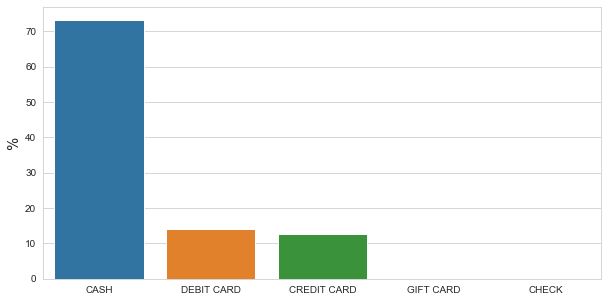

In [293]:
fig = plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
sns.barplot(sales.PAYMENT_METHOD.unique(),sales.PAYMENT_METHOD.value_counts()/len(sales)*100);
plt.ylabel('%',fontsize=15)
print(sales.PAYMENT_METHOD.value_counts())

### Outlet

8      21186
14     20757
7      16280
35     14739
56     14274
       ...  
139       40
140       29
4          9
86         2
141        2
Name: OUTLET_ID, Length: 130, dtype: int64


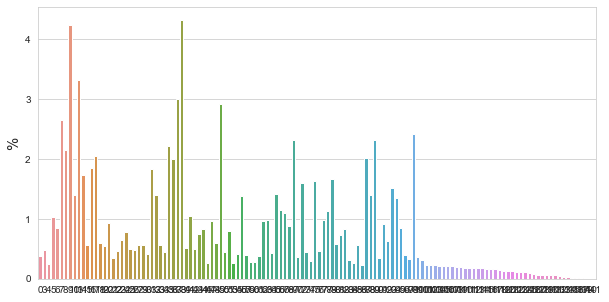

In [294]:
fig = plt.figure(figsize=(10,5))
sns.set_style('whitegrid')
sns.barplot(sales.OUTLET_ID.unique(),sales.OUTLET_ID.value_counts()/len(sales)*100);
plt.ylabel('%',fontsize=15)
print(sales.OUTLET_ID.value_counts())

In [ ]:
sales_detail['CATEGORY_ID'] = sales_detail.PRODUCT_ID.map(PRODUCT.set_index('PRODUCT_ID')['CATEGORY_ID'])

In [139]:
PRODUCT_0 = pd.read_csv('RETAIL_PRODUCT.csv',sep=';')
registry_0 = pd.read_csv('RETAIL_REGISTRY.csv',sep=',')
sales_0 = pd.read_csv('RETAIL_SALES.csv',sep=';')
sales_detail_0 = pd.read_csv('RETAIL_SALES_DETAIL.csv',sep=',')

/Users/pierfrancescomelucci/opt/anaconda3/envs/ENV/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [158]:
sales_detail_0[sales_detail_0.LIST_PRICE<0]

CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL
42       OV00404642  2020-01-17      114761       1.0        -5.0     NaN
449      DK00406358  2020-01-21       10256       1.0       -20.0     NaN
1341     SA00404954  2020-01-25       10256       1.0       -20.0     NaN
1403     FO00406280  2020-01-25       10256       1.0       -20.0     NaN
1419     RT05059892  2020-01-25      114761       1.0        -5.0     NaN
...             ...         ...         ...       ...         ...     ...
2046474  OC04412671  2019-04-27      114761       1.0        -5.0     NaN
2046564  PX04188897  2019-03-07       10268       1.0        -5.0     NaN
2046727  BY04340226  2019-04-27      114761       1.0        -5.0     NaN
2046878  OJ04358914  2019-04-12       10268       1.0        -5.0     NaN
2046888  KQ03892315  2019-04-17      114761       1.0        -5.0     NaN

[20385 rows x 6 columns]

In [157]:
sales_detail_0[sales_detail_0.QUANTITY<0]

CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL
3727     BI00867754  2019-05-16      138701      -1.0        0.00     NaN
4149     RT00405287  2019-05-16         864      -1.0       -7.45     NaN
4150     RT00405287  2019-05-16       88779      -1.0       -7.75     NaN
4151     RT00405287  2019-05-16      149356      -6.0      -16.50     NaN
8917     XI00405590  2019-06-22      187326      -1.0      -38.10     NaN
...             ...         ...         ...       ...         ...     ...
1978406  OB01102188  2019-04-25        1285      -1.0       -7.75     NaN
1978407  OB01102188  2019-04-25      130736      -1.0       -8.75     NaN
2015816  FS03633977  2018-10-03      128527      -1.0      -11.45     NaN
2020013  LE00386166  2018-12-28      151362      -1.0       -5.25     NaN
2029441  CS00770447  2019-03-13      128551      -1.0      -13.95     NaN

[343 rows x 6 columns]

In [182]:
a= pd.DataFrame(sales[sales.PAYMENT_METHOD == 'GIFT CARD'].TOTAL_POINTS.value_counts())
a[a.index<0].sum()


TOTAL_POINTS    22
dtype: int64

In [148]:
a = sales_detail_0[sales_detail_0.CUSTOMER_ID=='DJ00338421']
a[a.DATE=='2018-06-30']

CUSTOMER_ID        DATE  PRODUCT_ID  QUANTITY  LIST_PRICE SPECIAL
1056102  DJ00338421  2018-06-30         444       1.0        5.95     NaN
1056103  DJ00338421  2018-06-30         504       2.0       19.30     NaN
1056104  DJ00338421  2018-06-30        1969       1.0       11.65     NaN
1056105  DJ00338421  2018-06-30        2486       1.0       17.65     NaN
1056106  DJ00338421  2018-06-30        4095       1.0        0.05     NaN

In [ ]:
df['FREQ'] = df.puchaseoccasionhh.map(fre.set_index(freq.index)['puchaseoccasionhh'])